In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Read in Data

In [240]:
lstn = pd.read_csv('../data/prepped_training.csv')

In [3]:
validation = pd.read_csv('../data/prepped_validation.csv')

In [4]:
# The code below will aggregate the correlation coefficients between all columns which are not
#  price and log_price vs. price and log price

# This code using dictionaries was written with the help of the following sourece:
#  https://www.guru99.com/python-dictionary-append.html
corr_dict = {'name': [], 'price_corr':[], 'log_price_corr': [], 'magnitude': [], 'which': []}

# Get a list of all the columns to iterate through, remvoe price and log_price
col_list = list(lstn.columns)
col_list.remove('price')
col_list.remove('log_price')

# This loop creates data for each column
for col in col_list:
    
    # Find correlations to price and log_price
    p_corr = np.corrcoef(lstn[col], lstn['price'])[0][1]
    lp_corr = np.corrcoef(lstn[col], lstn['log_price'])[0][1]
    
    # Repor the higher magnitude value
    mag = max(abs(p_corr), abs(lp_corr))
    
    # Append the above data to the dictionary
    corr_dict['name'].append(col)
    corr_dict['price_corr'].append(p_corr)
    corr_dict['log_price_corr'].append(lp_corr)
    corr_dict['magnitude'].append(mag)
    
    # The if statement below will print which correaltion is stronger
    if abs(p_corr) > abs(lp_corr):
        corr_dict['which'].append('price')
    
    else:
        corr_dict['which'].append('log_price')

# Create a dataframe from the dictionary
corr_df = pd.DataFrame(corr_dict)

# Set the index to be the column names collected as there is no need for a numerical index
corr_df.set_index('name', inplace=True)
corr_df.head()

price_corr  log_price_corr  magnitude      which
name                                                                       
host_since                   0.039550        0.027396   0.039550      price
host_response_rate          -0.003495        0.041759   0.041759  log_price
host_acceptance_rate         0.130797        0.271477   0.271477  log_price
host_listings_count          0.016601        0.136672   0.136672  log_price
host_total_listings_count   -0.011012        0.082024   0.082024  log_price

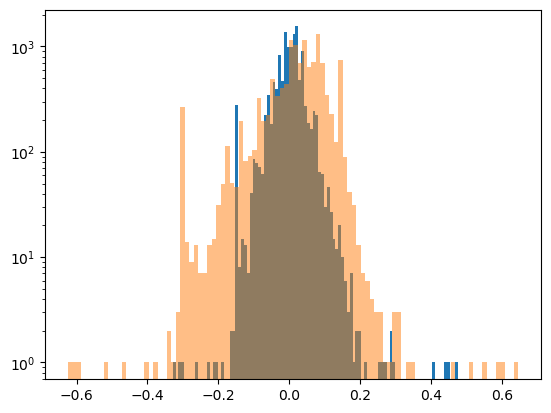

In [5]:
# Plot an overlapping histogram of the correlation distributions
plt.hist(corr_df.price_corr, bins = 100)
plt.hist(corr_df.log_price_corr, bins = 100, alpha = 0.5)
plt.yscale('log')
plt.show();

In [6]:
# Create a dataframe sorted by the correlation magnitude
corr_df_sorted = corr_df.sort_values(by = 'magnitude', ascending=False)

# Create an empty list to store the column names
best_columns = []

# Create an index to loop through
bc_index = 0

# Write a while loop to get the top 30 most highly correlated columns which are
#  not already duplicated in the list with either their log or non-log counterparts
while len(best_columns) < 30:
    
    # simplify the name of the individual column names pulled out of the df index
    next_column = corr_df_sorted.index[bc_index]
    
    # If the log version not is already there, and if the non-log version of the colunm
    #  name are not already there, then add the column name
    if f'log_{next_column}' not in best_columns and next_column.replace('log_', '') not in best_columns:
        best_columns.append(next_column)
    
    # Increase the index value by 1
    bc_index += 1

In [7]:
# View the most highly correlated variables above in the correlation dataframe
corr_df_sorted.loc[best_columns]

price_corr  log_price_corr  \
name                                                                           
log_accommodates                                    0.437727        0.647343   
room_type_Private room                             -0.328703       -0.625225   
pcnt_private                                       -0.310895       -0.605388   
pcnt_ent_homes                                      0.292924        0.598974   
property_type_Private room in rental unit          -0.258554       -0.519602   
log_beds                                            0.405373        0.516437   
log_calculated_host_listings_count_private_rooms   -0.226114       -0.462623   
bathrooms_text_1 shared bath                       -0.207068       -0.397327   
amen_Lock on bedroom door                          -0.208319       -0.381361   
description_shared                                 -0.185039       -0.343221   
bathrooms_text_2 baths                              0.254731        0.342915   
host_about_shared                                  -0.166520       -0.339879   
amen_Hair dryer                                     0.156992        0.335156   
name_room                                          -0.156941       -0.315639   
property_type_Entire rental unit                    0.089294        0.315240   
description_room in                                -0.140605       -0.313415   
log_amen_cnt                                        0.171321        0.311090   
amen_Pets allowed                                   0.162390        0.310873   
host_about_there to                                -0.150796       -0.308152   
minimum_nights                                     -0.144075       -0.304003   
description_about this home                        -0.146687       -0.299563   
host_about_experience of                           -0.147430       -0.298365   
log_bedrooms                                        0.287903        0.297510   
description_space br about                         -0.145318       -0.297490   
description_the space br about                     -0.145318       -0.297490   
description_this home br br                        -0.145318       -0.297490   
description_space br about this                    -0.145318       -0.297490   
description_about this home br                     -0.145318       -0.297490   
description_br about this home                     -0.145318       -0.297490   
host_about_to rent                                 -0.147128       -0.296548   

                                                  magnitude      which  
name                                                                    
log_accommodates                                   0.647343  log_price  
room_type_Private room                             0.625225  log_price  
pcnt_private                                       0.605388  log_price  
pcnt_ent_homes                                     0.598974  log_price  
property_type_Private room in rental unit          0.519602  log_price  
log_beds                                           0.516437  log_price  
log_calculated_host_listings_count_private_rooms   0.462623  log_price  
bathrooms_text_1 shared bath                       0.397327  log_price  
amen_Lock on bedroom door                          0.381361  log_price  
description_shared                                 0.343221  log_price  
bathrooms_text_2 baths                             0.342915  log_price  
host_about_shared                                  0.339879  log_price  
amen_Hair dryer                                    0.335156  log_price  
name_room                                          0.315639  log_price  
property_type_Entire rental unit                   0.315240  log_price  
description_room in                                0.313415  log_price  
log_amen_cnt                                       0.311090  log_price  
amen_Pets allowed                                  0.310873  log_price  
host_about_there to          

In [8]:
# Filter the original training data with only the columns above:
lstn_best = lstn[best_columns]

# Append the log_price column
lstn_best['log_price'] = lstn.log_price

lstn_best.head()

C:\Users\Dan\AppData\Local\Temp\ipykernel_7636\2672393132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstn_best['log_price'] = lstn.log_price


log_accommodates  room_type_Private room  pcnt_private  pcnt_ent_homes  \
0          1.609438                     0.0         0.000           1.000   
1          1.386294                     0.0         0.000           1.000   
2          0.000000                     1.0         1.000           0.000   
3          0.693147                     1.0         0.982           0.018   
4          2.772589                     0.0         0.000           1.000   

   property_type_Private room in rental unit  log_beds  \
0                                        0.0  0.693147   
1                                        0.0  0.693147   
2                                        1.0  0.000000   
3                                        1.0  0.000000   
4                                        0.0  1.609438   

   log_calculated_host_listings_count_private_rooms  \
0                                          0.000000   
1                                          0.000000   
2                                          3.433987   
3                                          5.613128   
4                                          0.000000   

   bathrooms_text_1 shared bath  amen_Lock on bedroom door  \
0                           0.0                          0   
1                           0.0                          0   
2                           0.0                          1   
3                           0.0                          0   
4                           0.0                          0   

   description_shared  ...  host_about_experience of  log_bedrooms  \
0                   0  ...                         0      0.693147   
1                   1  ...                         0      0.000000   
2                   1  ...                         0      0.000000   
3                   1  ...                         1      1.386294   
4                   0  ...                         0      1.386294   

   description_space br about  description_the space br about  \
0                           0                               0   
1                           0                               0   
2                           0                               0   
3                           1                               1   
4                           0                               0   

   description_this home br br  description_space br about this  \
0                            0                                0   
1                            0                                0   
2                            0                                0   
3                            1                                1   
4                            0                                0   

   description_about this home br  description_br about this home  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               1                               1   
4                               0                               0   

   host_about_to rent  log_price  
0                   0   5.484797  
1                   0   5.669881  
2                   0   3.583519  
3                   1   4.290459  
4                   0   6.656727  

[5 rows x 31 columns]

<Axes: >

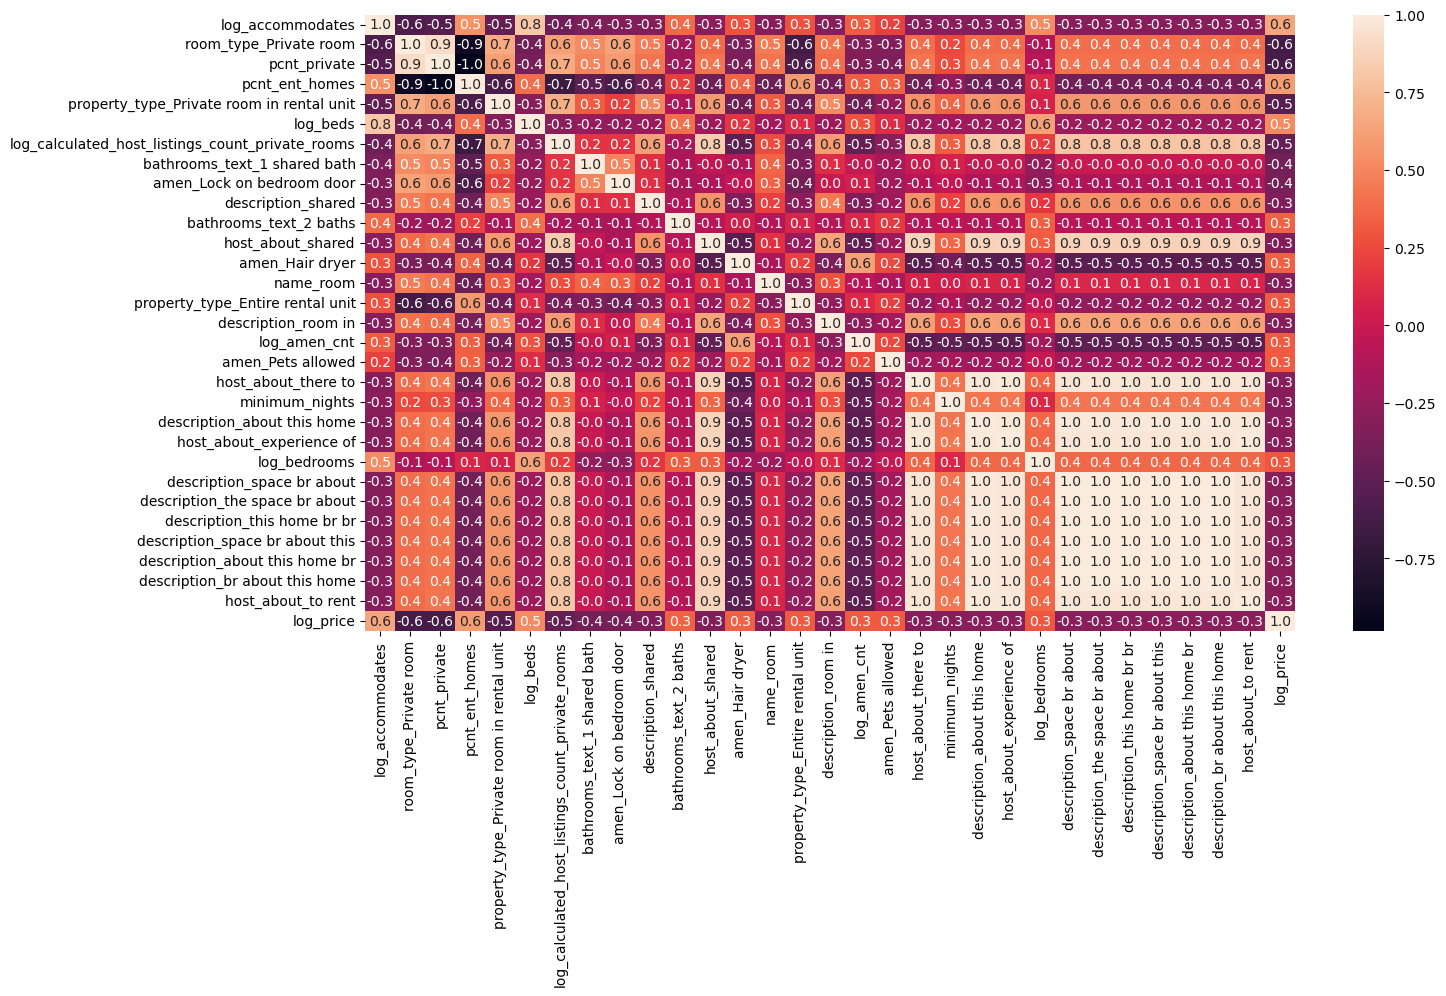

In [9]:
plt.figure(figsize = (15, 8))
sns.heatmap(lstn_best.corr(), annot = True, fmt='.1f')

In [10]:
best_cols_no_mc = [best_columns[0]]

for col in best_columns:
    # print(best_cols_no_mc)
    # print(col)
    corrcoefs = []
    
    for col_no_mc in best_cols_no_mc:
        #print(col_no_mc)
        corr_mc = np.corrcoef(lstn[col], lstn[col_no_mc])[0][1]
        corrcoefs.append(abs(corr_mc))
        #print(f'{col} vs. {col_no_mc}: {corr_mc}')
    
    if max(corrcoefs) < 0.7:
        best_cols_no_mc.append(col)
        #print('yes!\n')
    
    #else:
        #print('no!\n')

In [11]:
best_cols_no_mc_copy = best_cols_no_mc.copy()
best_cols_no_mc_copy.append('log_price')

<Axes: >

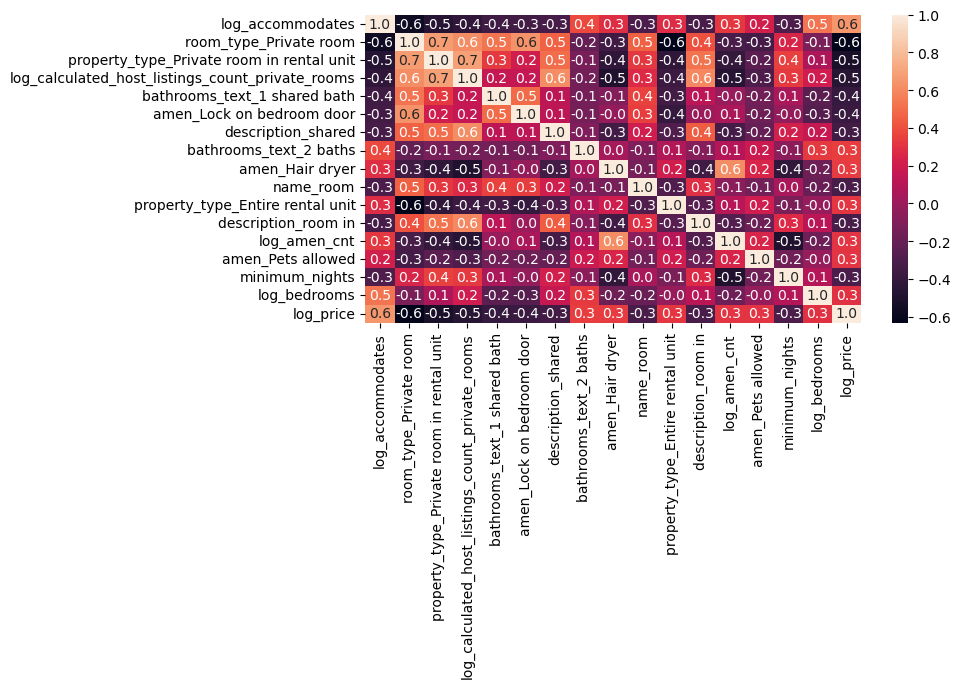

In [12]:
plt.figure(figsize = (8, 4))
sns.heatmap(lstn[best_cols_no_mc_copy].corr(), annot = True, fmt='.1f')

In [13]:
validation['log_price']

0      5.351858
1      5.459586
2      5.293305
3      5.181784
4      3.583519
         ...   
691    4.394449
692    6.354370
693    6.327937
694    6.536692
695    5.420535
Name: log_price, Length: 696, dtype: float64

# Build a Basic Linear Regression Model

In [14]:
X_train, y_train = lstn_best[best_cols_no_mc], lstn['log_price']
X_val, y_val = validation[best_cols_no_mc], validation['log_price']

In [15]:
lr = LinearRegression()

lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_val, y_val)

(0.5651106876838519, 0.5528688076929335)

In [16]:
r2_score(lstn['price'], np.exp(lr.predict(X_train)))

0.2236900979956813

In [17]:
r2_score(validation['price'], np.exp(lr.predict(X_val)))

0.040581432848077914

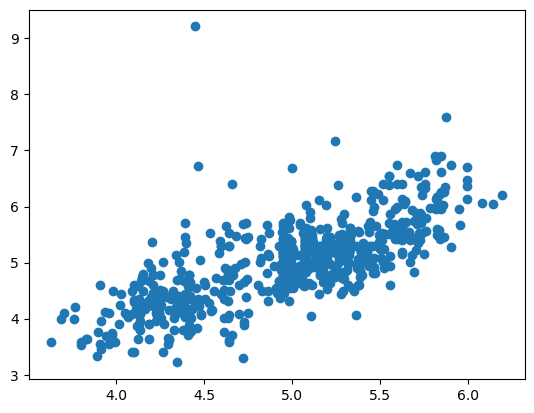

In [18]:
plt.scatter((lr.predict(X_val)), validation['log_price']);

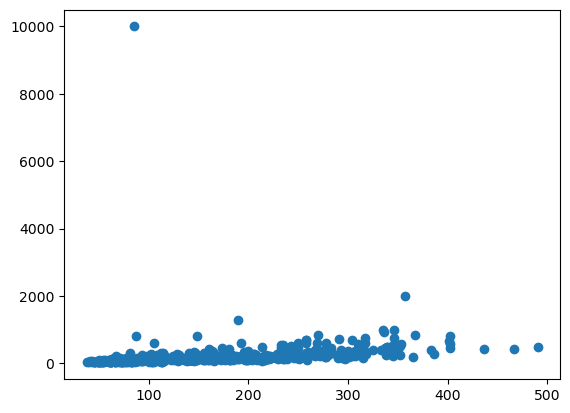

(0.0, 1000.0)

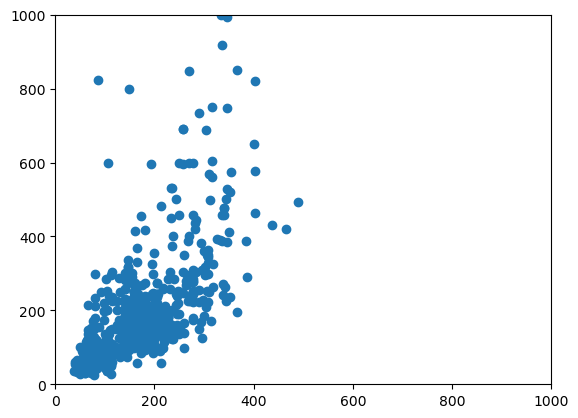

In [19]:
plt.scatter(np.exp(lr.predict(X_val)), validation['price'])
plt.show()

plt.scatter(np.exp(lr.predict(X_val)), validation['price'])
plt.ylim(0, 1000)
plt.xlim(0, 1000)

# Automate Modeling Process

In [118]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def data_X_maker(data_train, data_val, col_list, col_list_name):
    globals()[f'X_train_{col_list_name}']  = data_train[col_list]
    #print(f'X_train_{col_list_name}')
    
    globals()[f'X_val_{col_list_name}'] = data_val[col_list]
    #print(f'X_val_{col_list_name}')
    
    # Create common y datasets:
    globals()[f'y_train_{col_list_name}'] = data_train['price']
    #print(f'y_train_{col_list_name}')
    
    globals()[f'y_val_{col_list_name}'] = data_val['price']
    #print(f'y_val_{col_list_name}')
    
    globals()[f'y_train_log_{col_list_name}'] = data_train['log_price']
    #print(f'y_train_log_{col_list_name}')
    
    globals()[f'y_val_log_{col_list_name}'] = data_val['log_price']
    #print(f'y_val_log_{col_list_name}')
    
    globals()[f'data_list_{col_list_name}'] = [
        globals()[f'X_train_{col_list_name}'],
        globals()[f'X_val_{col_list_name}'],
        globals()[f'y_train_{col_list_name}'],
        globals()[f'y_val_{col_list_name}'],
        globals()[f'y_train_log_{col_list_name}'],
        globals()[f'y_val_log_{col_list_name}']
    ]
    print(f'data_list_{col_list_name}')
    
    return globals()[f'data_list_{col_list_name}']

def model_maker(data_list, col_list_name, mod_list):
    
    # Import data from a data list grabbing each component by index
    # X Data
    X_train_df = data_list[0]
    X_val_df = data_list[1]
    
    print(f'{X_train_df.shape}')
    
    # y datasets:
    y_train = data_list[2]
    y_val = data_list[3]
    
    y_train_log = data_list[4]
    y_val_log = data_list[5]

    # This is to change colors for each model so they're easier to identify
    color_code = 0
    
    # This is a dictionary which will house all metrics comupted in this loop
    modeling_dictionary = {'col_data': [], 
                 'model':[], 
                 'R2 training, price': [], 
                 'R2 training, log_price': [], 
                 'RMSE training, price': [],
                 'RMSE training, log_price': [],
                 'R2 validation, price': [],
                 'R2 validation, log_price': [],
                 'RMSE validation, price': [],
                 'RMSE validation, log_price': []                 
                }

    # Run the for loop to run all models in the input list on the data
    for model in mod_list:
        
        # **************  PRICE MODEL  ****************************************
        # Run Models on price
        model_inst = model
        model_inst.fit(X_train_df, y_train)
        
        # Scores      
        preds_price_train = model_inst.predict(X_train_df)
        preds_price_val = model_inst.predict(X_val_df)
        
        r2_train_price = round(model_inst.score(X_train_df, y_train), 3)
        r2_val_price = round(r2_score(y_val, preds_price_val), 3)
        
        #r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)
        
        
        rmse_train_price = round(mean_squared_error(y_train, preds_price_train, squared = False), 3)
        rmse_val_price = round(mean_squared_error(y_val, preds_price_val, squared = False), 3)
        
        
        # ***************  LOG PRICE MODEL  ***************************************
        # Run models on log price
        model_inst_log = model
        model_inst_log.fit(X_train_df, y_train_log)
        
        # Scores
        preds_log_price_train = np.exp(model_inst_log.predict(X_train_df))
        preds_log_price_val = np.exp(model_inst_log.predict(X_val_df))
        
        r2_train_log_price = round(r2_score(y_train, preds_log_price_train), 3)
        r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)

        rmse_train_log_price = round(mean_squared_error(y_train, preds_log_price_train, squared = False), 3)
        rmse_val_log_price = round(mean_squared_error(y_val, preds_log_price_val, squared = False), 3)
        
        
        # Append values to dictionary:
        modeling_dictionary['col_data'].append(col_list_name)
        modeling_dictionary['model'].append(f'{model}'), 
        modeling_dictionary['R2 training, price'].append(r2_train_price) 
        modeling_dictionary['R2 training, log_price'].append(r2_train_log_price) 
        modeling_dictionary['RMSE training, price'].append(rmse_train_price)
        modeling_dictionary['RMSE training, log_price'].append(rmse_train_log_price)
        modeling_dictionary['R2 validation, price'].append(r2_val_price)
        modeling_dictionary['R2 validation, log_price'].append(r2_val_log_price)
        modeling_dictionary['RMSE validation, price'].append(rmse_val_price)
        modeling_dictionary['RMSE validation, log_price'].append(rmse_val_log_price)

        # Print the metrics so they can be viewed
        print('\n')
        print('=' * 50)       
        print(f'R2 training, price: {r2_train_price}')
        print(f'R2 training, log_price: {r2_train_log_price}')
        
        print(f'RMSE training, price: {rmse_train_price}')
        print(f'RMSE training, log_price: {rmse_train_log_price}\n')
        
        #print('\n')
        print(f'R2 validation, price: {r2_val_price}')
        print(f'R2 validation, log_price: {r2_val_log_price}')
        
        print(f'RMSE validation, price: {rmse_val_price}')
        print(f'RMSE validation, log_price: {rmse_val_log_price}')
        
        
        print('=' * 50)
                        
        plt.figure(figsize = (10, 8))
        plt.subplots_adjust(hspace=0.6)
        
        plt.subplot(2, 2, 1)
        plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
        plt.scatter(y_train, preds_price_train, color = f'C{color_code}')
        plt.xlabel('True Prices')
        plt.ylabel('Predicted Prices')
        
        plt.subplot(2, 2, 2)
        plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
        plt.scatter(y_train, preds_log_price_train, color = f'C{color_code}')
        plt.xlabel('True Prices')
        plt.ylabel('Predicted Prices')
        
        plt.subplot(2, 2, 3)
        plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
        plt.scatter(y_val, preds_price_val, color = f'C{color_code}')
        plt.xlabel('True Prices')        
        plt.ylabel('Predicted Prices')
        
        plt.subplot(2, 2, 4)
        plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
        plt.scatter(y_val, preds_log_price_val, color = f'C{color_code}')
        plt.xlabel('True Prices')
        plt.ylabel('Predicted Prices')
        
        plt.show()
        
        # Up the color code for the next model
        color_code += 1
    
    '''
    The follwoing formatting code was inspired by the following sources:
    * My project 3
    * https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
    * https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.highlight_max.html
    * Assking ChatGPT:  "i need an example of using the subset argument in a pandas dataframe formatted with style.highlight_max"
    * https://medium.com/gustavorsantos/how-to-highlight-max-min-or-nulls-with-pandas-f2df5bf4ccf9
    '''
    return pd.DataFrame(modeling_dictionary).style\
.highlight_max(subset = ['R2 training, price', 'R2 training, log_price', 'R2 validation, price', 'R2 validation, log_price'], color = 'darkred')\
.highlight_min(subset = ['RMSE training, price', 'RMSE training, log_price', 'RMSE validation, price', 'RMSE validation, log_price'], color = 'blue')

       # ['R2 training, price', 'R2 training, log_price', 'R2 validation, price', 'R2 validation, log_price']
       # modeling_dictionary['R2 training, price'].append(r2_train_price) 
       #  modeling_dictionary['R2 training, log_price'].append(r2_train_log_price) 
       #  modeling_dictionary['RMSE training, price'].append(r2_val_price)
       #  modeling_dictionary['RMSE training, log_price'].append(rmse_train_log_price)
       #  modeling_dictionary['R2 validation, price'].append(rmse_train_price)
       #  modeling_dictionary['R2 validation, log_price'].append(r2_val_log_price)
       #  modeling_dictionary['RMSE validation, price'].append(rmse_val_price)
       #  modeling_dictionary['RMSE validation, log_price'].append(rmse_val_log_price)

In [21]:
# Make a list of models to run!
list_of_models = [LinearRegression(), RandomForestRegressor(), BaggingRegressor(), GradientBoostingRegressor(), ExtraTreesRegressor(), AdaBoostRegressor(), DecisionTreeRegressor()]

In [121]:
data_X_maker(lstn, validation, best_cols_no_mc, 'best_cols_no_mc');

data_list_best_cols_no_mc


data_list_best_cols_no_mc
(2781, 16)


R2 training, price: 0.236
R2 training, log_price: 0.224
RMSE training, price: 182.061
RMSE training, log_price: 183.556

R2 validation, price: 0.043
R2 validation, log_price: 0.041
RMSE validation, price: 398.155
RMSE validation, log_price: 398.624


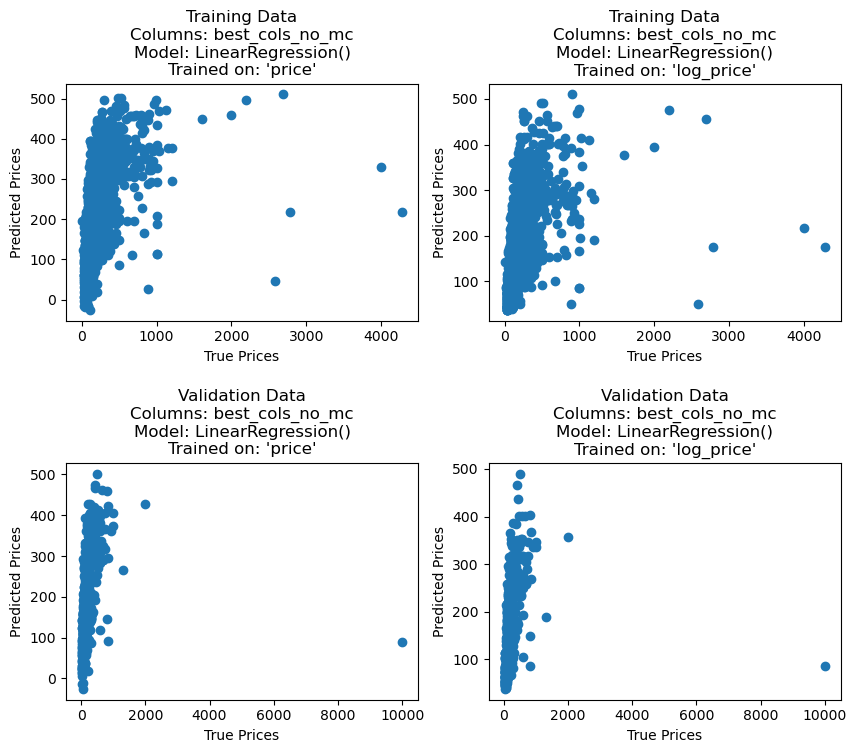



R2 training, price: 0.858
R2 training, log_price: 0.761
RMSE training, price: 78.374
RMSE training, log_price: 101.915

R2 validation, price: 0.071
R2 validation, log_price: 0.054
RMSE validation, price: 392.316
RMSE validation, log_price: 395.826


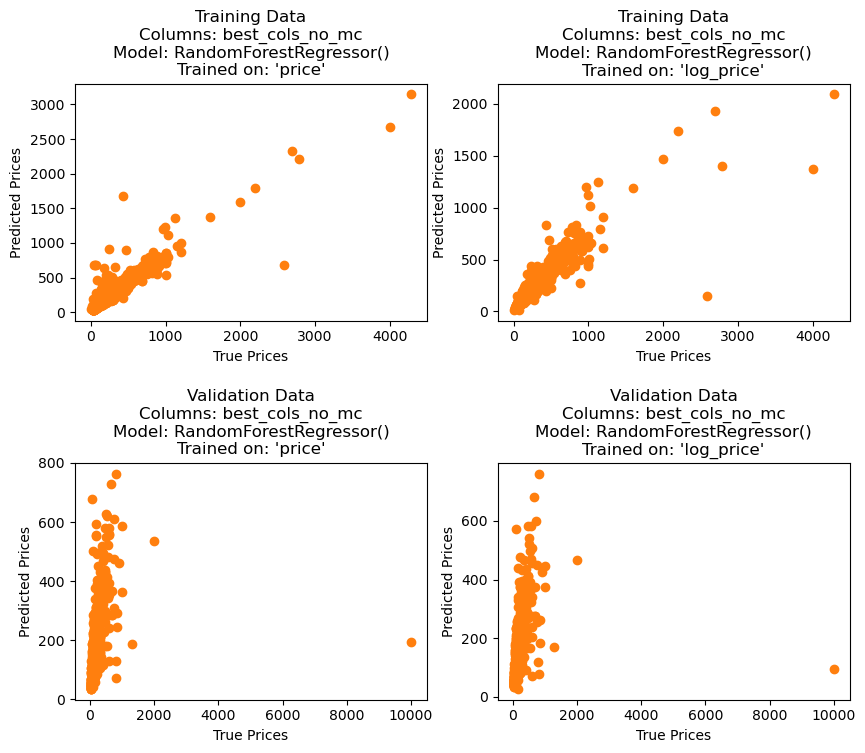



R2 training, price: 0.814
R2 training, log_price: 0.788
RMSE training, price: 89.953
RMSE training, log_price: 95.837

R2 validation, price: 0.069
R2 validation, log_price: 0.052
RMSE validation, price: 392.689
RMSE validation, log_price: 396.229


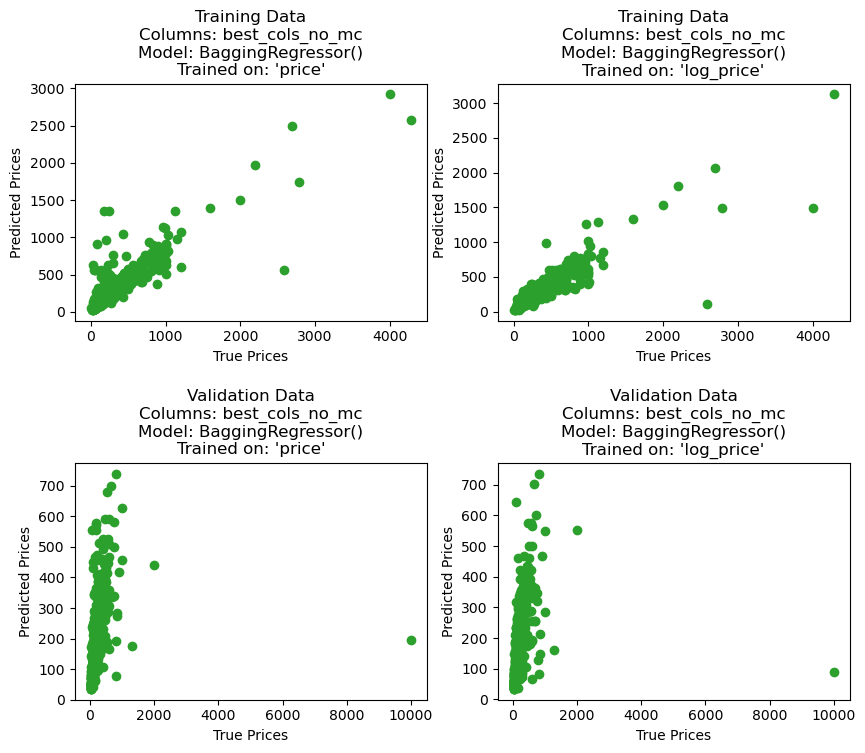



R2 training, price: 0.558
R2 training, log_price: 0.39
RMSE training, price: 138.536
RMSE training, log_price: 162.734

R2 validation, price: 0.061
R2 validation, log_price: 0.055
RMSE validation, price: 394.429
RMSE validation, log_price: 395.662


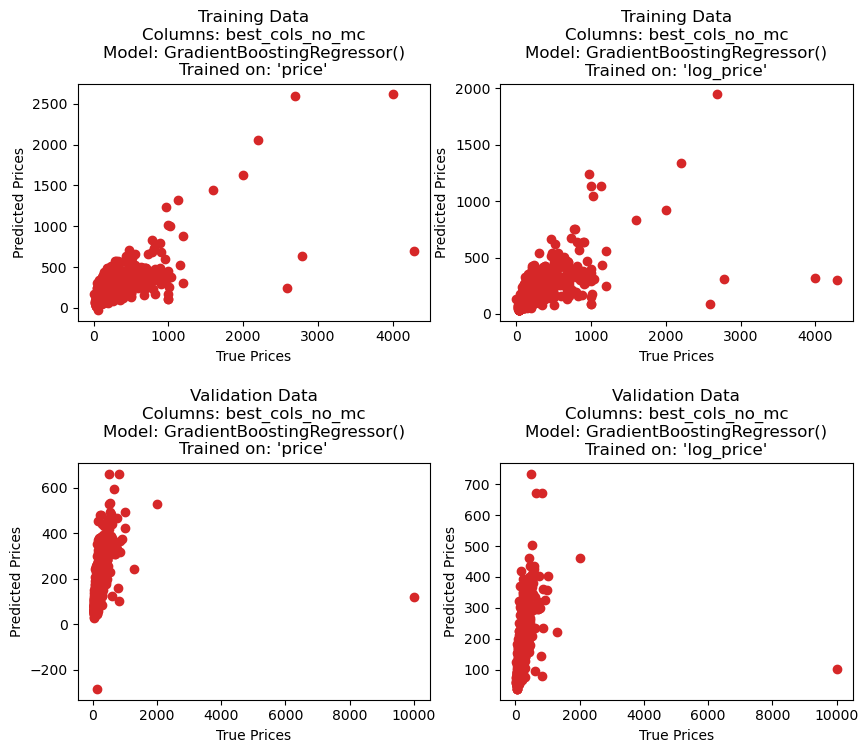



R2 training, price: 0.95
R2 training, log_price: 0.94
RMSE training, price: 46.683
RMSE training, log_price: 51.231

R2 validation, price: 0.018
R2 validation, log_price: 0.042
RMSE validation, price: 403.316
RMSE validation, log_price: 398.431


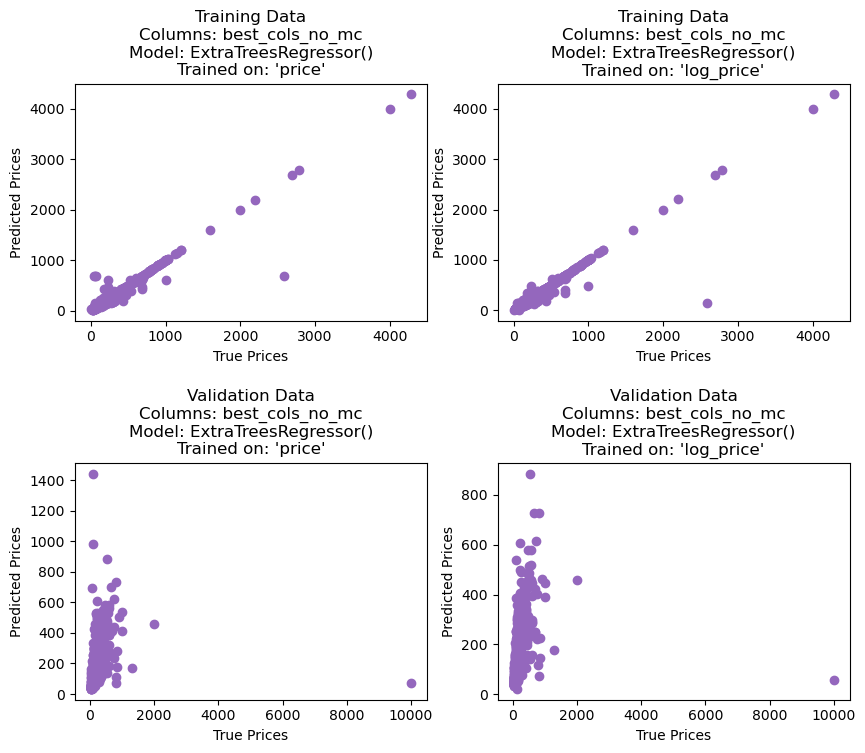



R2 training, price: 0.279
R2 training, log_price: 0.256
RMSE training, price: 176.857
RMSE training, log_price: 179.637

R2 validation, price: -0.012
R2 validation, log_price: 0.046
RMSE validation, price: 409.31
RMSE validation, log_price: 397.543


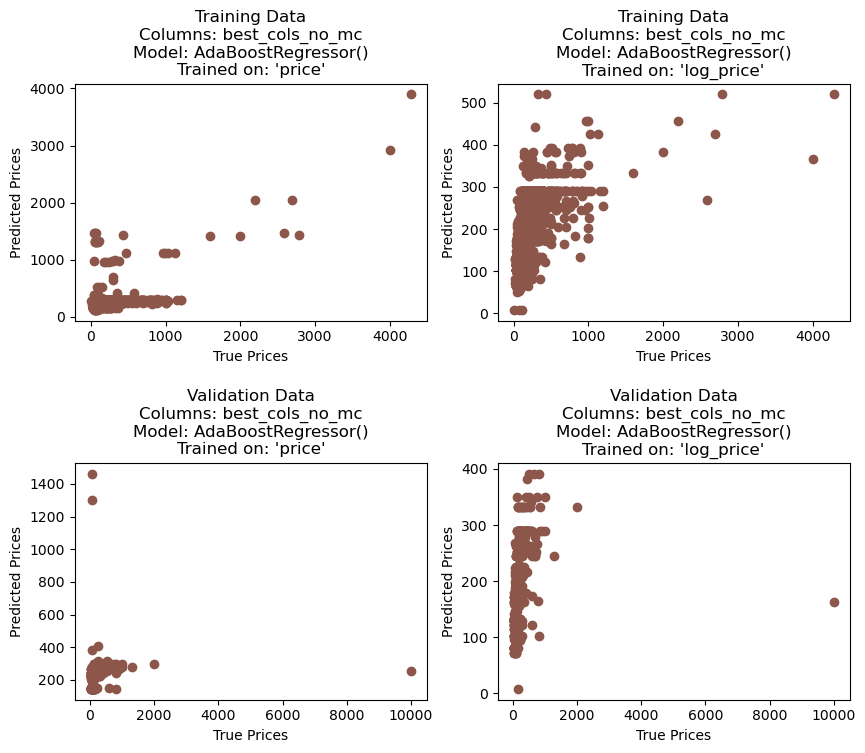



R2 training, price: 0.95
R2 training, log_price: 0.94
RMSE training, price: 46.681
RMSE training, log_price: 51.231

R2 validation, price: 0.013
R2 validation, log_price: 0.018
RMSE validation, price: 404.398
RMSE validation, log_price: 403.196


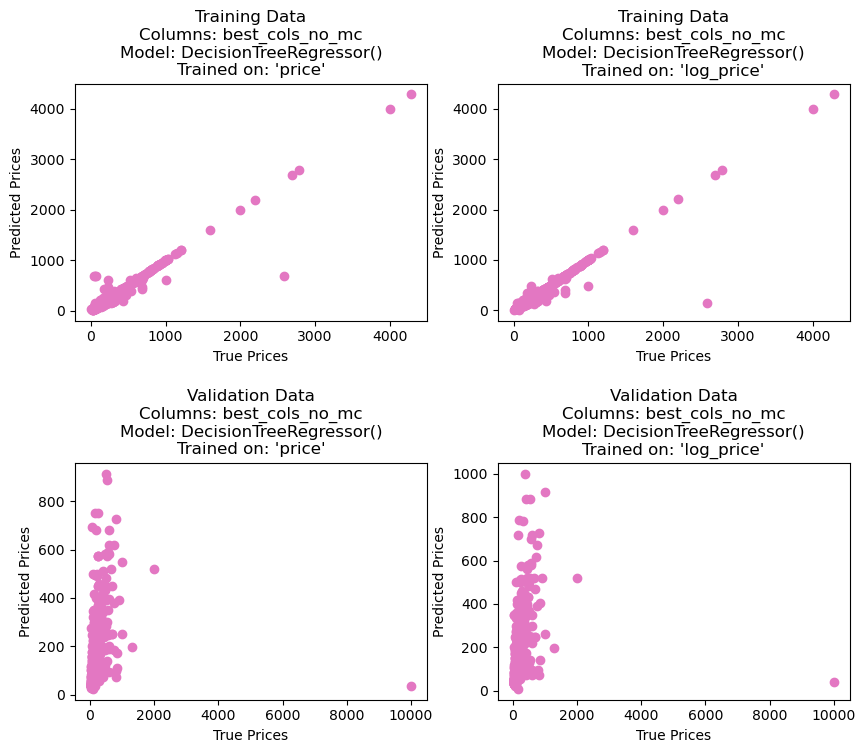

In [122]:
# Run the data maker function inside of the model maker function
model_maker(data_X_maker(lstn, validation, best_cols_no_mc, 'best_cols_no_mc'), 
            'best_cols_no_mc', 
            list_of_models)

#  See what happens when the high-priced listings are filtered out

data_list_best_cols_no_mc
(2409, 16)


R2 training, price: 0.51
R2 training, log_price: 0.488
RMSE training, price: 48.291
RMSE training, log_price: 49.346

R2 validation, price: 0.496
R2 validation, log_price: 0.454
RMSE validation, price: 49.474
RMSE validation, log_price: 51.522


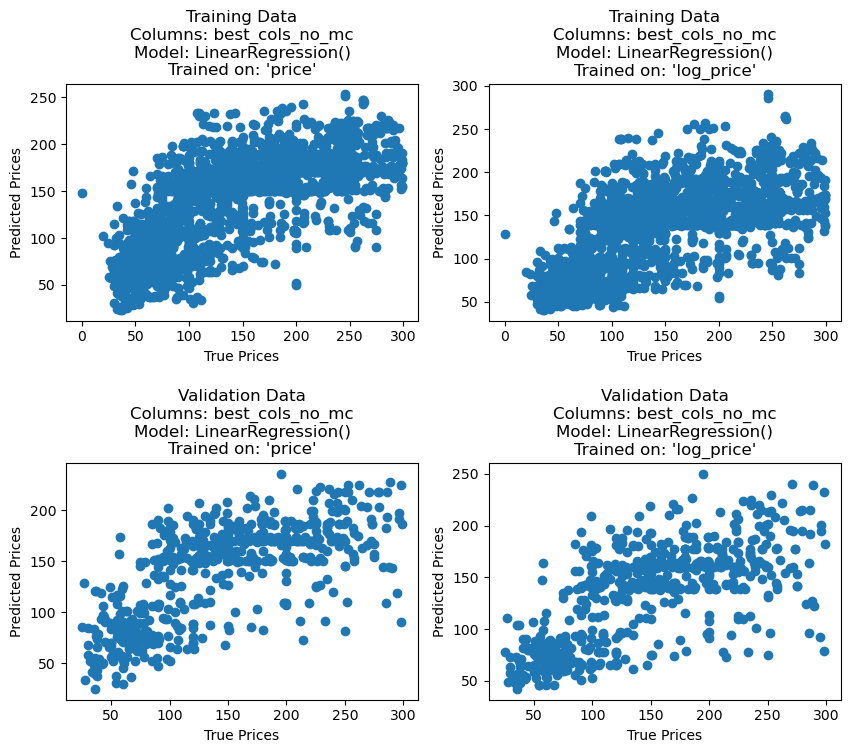



R2 training, price: 0.923
R2 training, log_price: 0.914
RMSE training, price: 19.195
RMSE training, log_price: 20.201

R2 validation, price: 0.582
R2 validation, log_price: 0.576
RMSE validation, price: 45.052
RMSE validation, log_price: 45.377


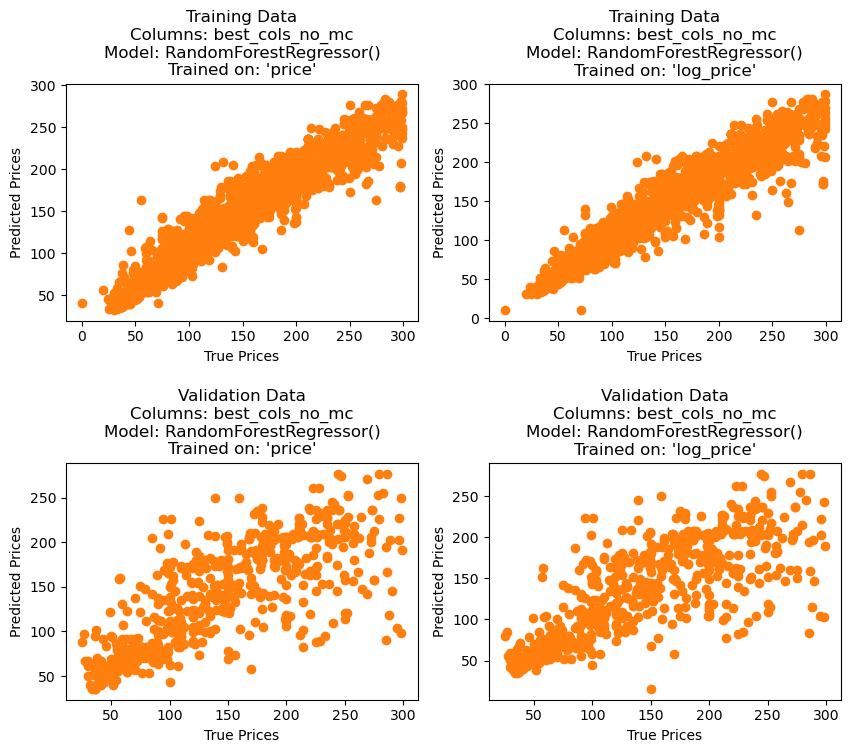



R2 training, price: 0.906
R2 training, log_price: 0.898
RMSE training, price: 21.198
RMSE training, log_price: 22.0

R2 validation, price: 0.569
R2 validation, log_price: 0.579
RMSE validation, price: 45.769
RMSE validation, log_price: 45.244


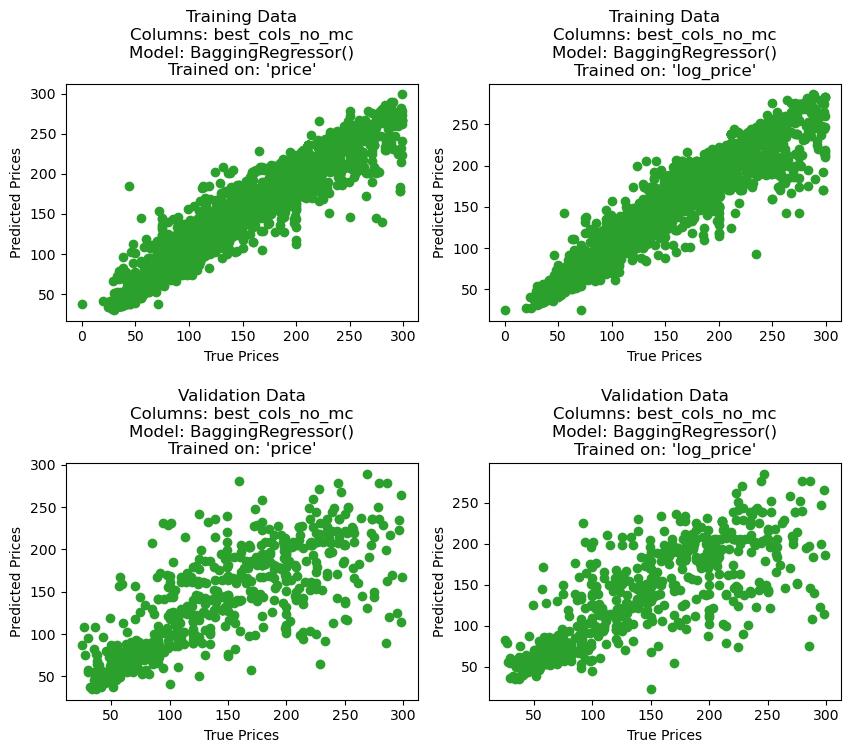



R2 training, price: 0.668
R2 training, log_price: 0.642
RMSE training, price: 39.757
RMSE training, log_price: 41.293

R2 validation, price: 0.594
R2 validation, log_price: 0.555
RMSE validation, price: 44.422
RMSE validation, log_price: 46.494


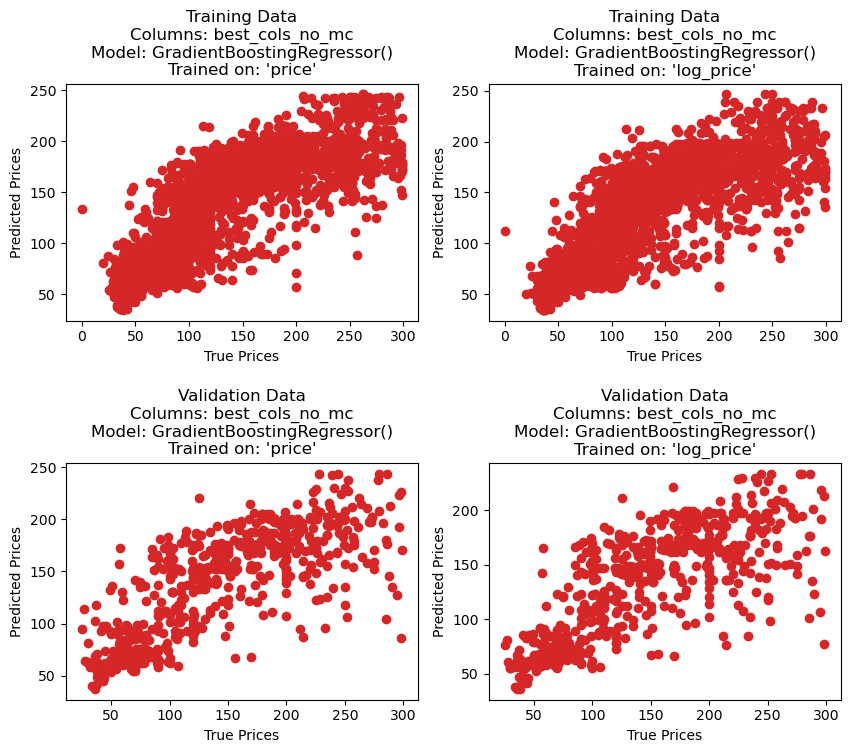



R2 training, price: 0.965
R2 training, log_price: 0.964
RMSE training, price: 12.928
RMSE training, log_price: 13.077

R2 validation, price: 0.533
R2 validation, log_price: 0.525
RMSE validation, price: 47.654
RMSE validation, log_price: 48.072


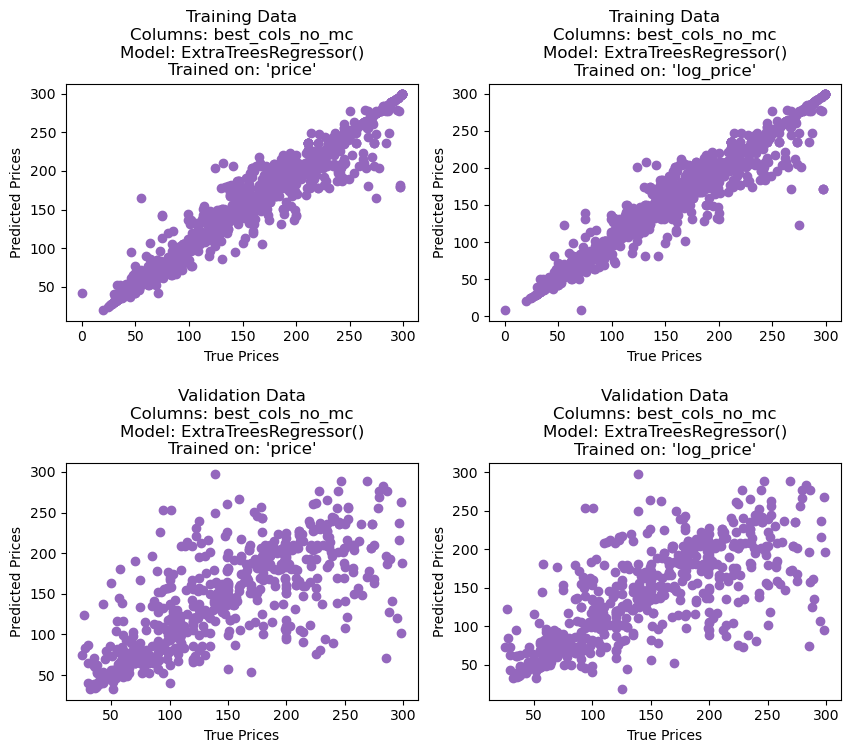



R2 training, price: 0.486
R2 training, log_price: 0.469
RMSE training, price: 49.455
RMSE training, log_price: 50.274

R2 validation, price: 0.488
R2 validation, log_price: 0.414
RMSE validation, price: 49.893
RMSE validation, log_price: 53.385


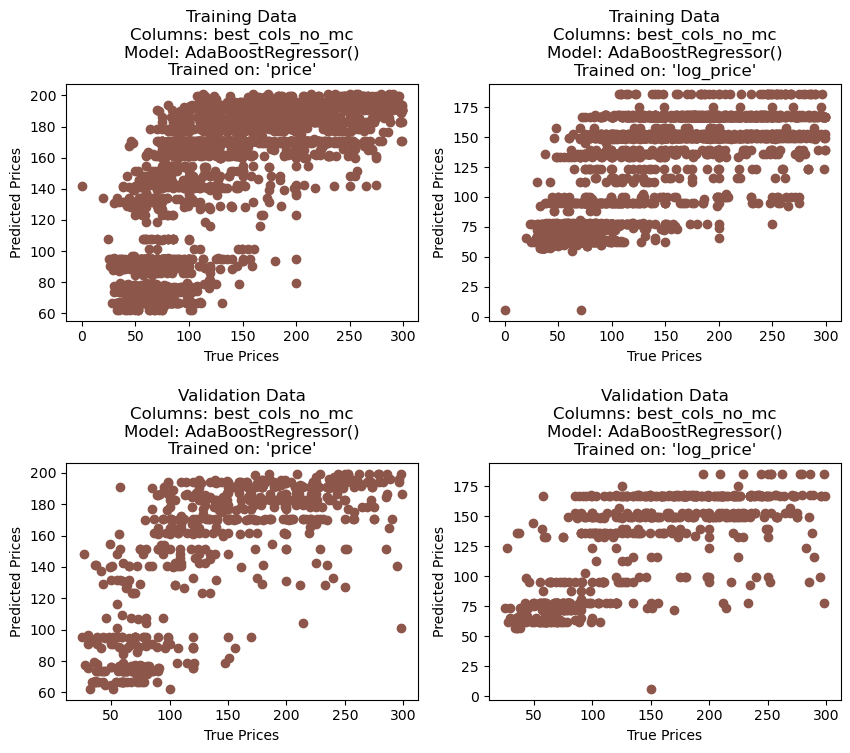



R2 training, price: 0.965
R2 training, log_price: 0.964
RMSE training, price: 12.925
RMSE training, log_price: 13.077

R2 validation, price: 0.324
R2 validation, log_price: 0.414
RMSE validation, price: 57.331
RMSE validation, log_price: 53.391


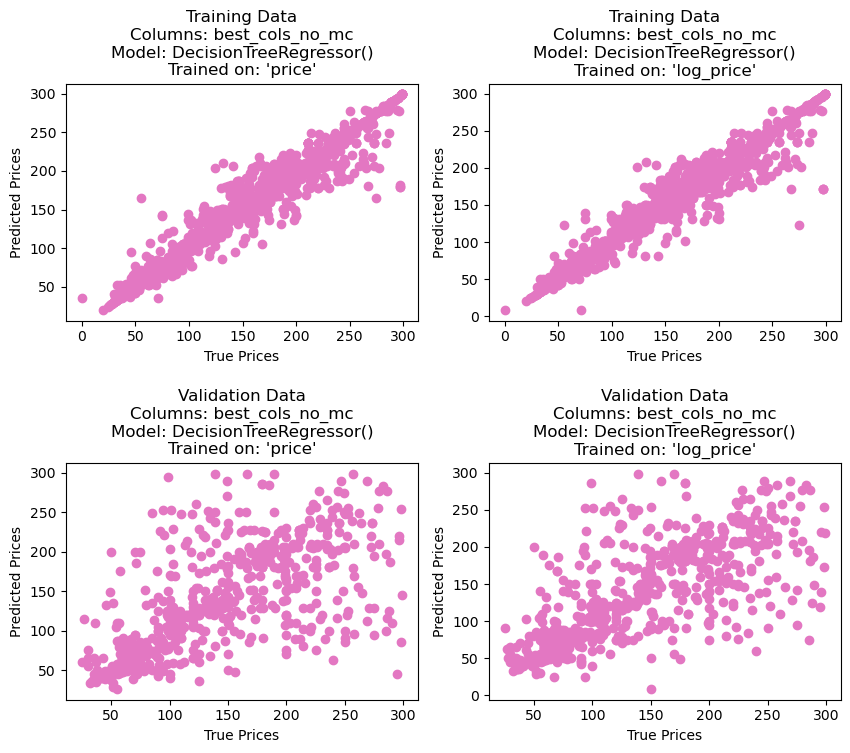

In [23]:
# Run the data maker function inside of the model maker function
model_maker(data_X_maker(lstn[lstn.price < 300], validation[validation.price < 300], best_cols_no_mc, 'best_cols_no_mc'), 
            'best_cols_no_mc', 
            list_of_models)

data_list_best_columns
(2781, 30)


R2 training, price: 0.249
R2 training, log_price: 0.226
RMSE training, price: 180.592
RMSE training, log_price: 183.281

R2 validation, price: 0.038
R2 validation, log_price: 0.04
RMSE validation, price: 399.213
RMSE validation, log_price: 398.652


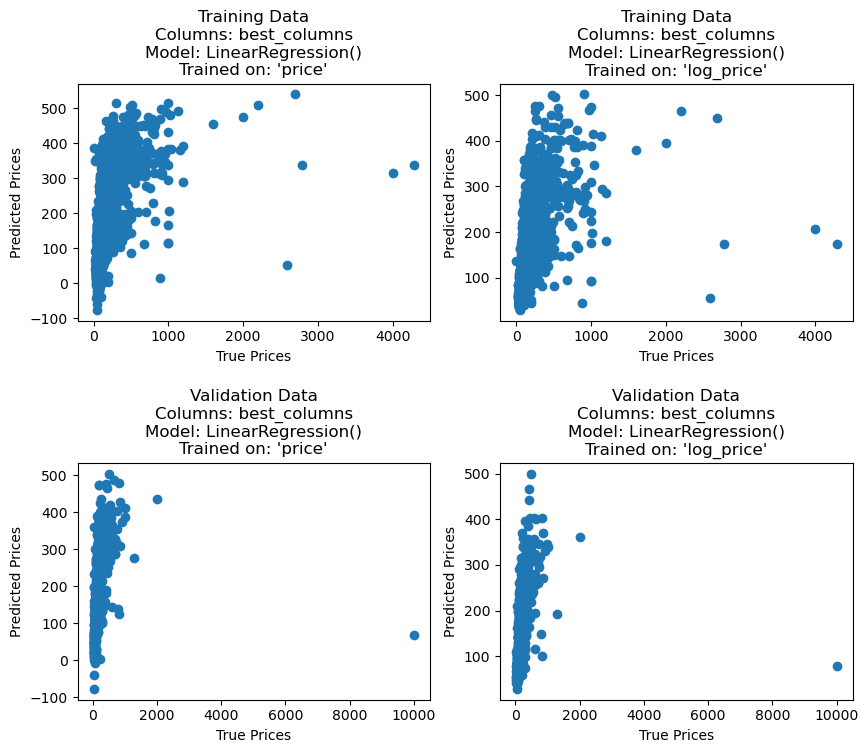



R2 training, price: 0.859
R2 training, log_price: 0.766
RMSE training, price: 78.339
RMSE training, log_price: 100.758

R2 validation, price: 0.049
R2 validation, log_price: 0.055
RMSE validation, price: 396.894
RMSE validation, log_price: 395.62


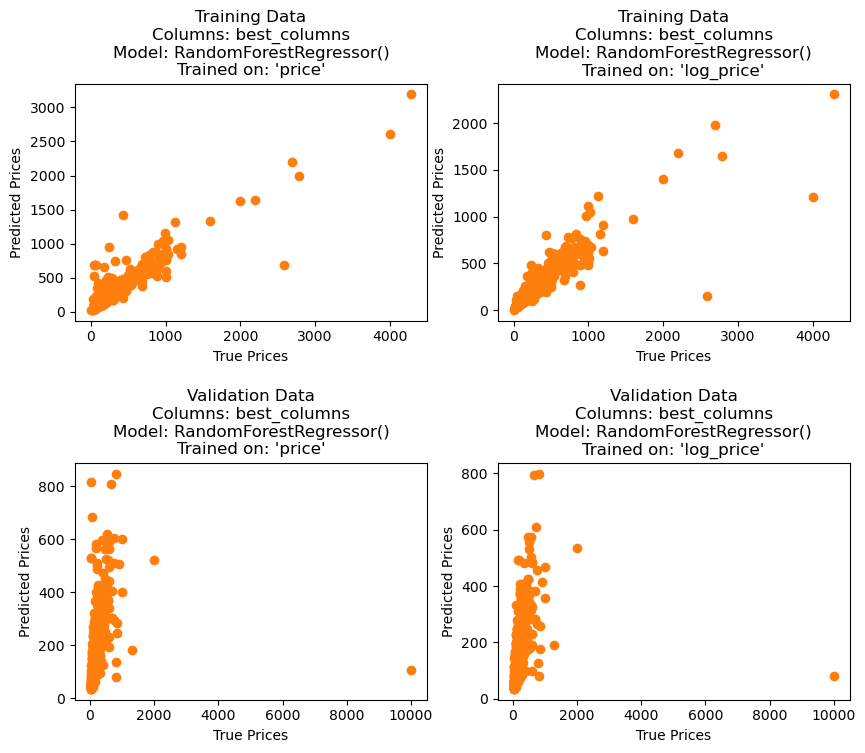



R2 training, price: 0.824
R2 training, log_price: 0.655
RMSE training, price: 87.376
RMSE training, log_price: 122.291

R2 validation, price: 0.054
R2 validation, log_price: 0.05
RMSE validation, price: 395.9
RMSE validation, log_price: 396.578


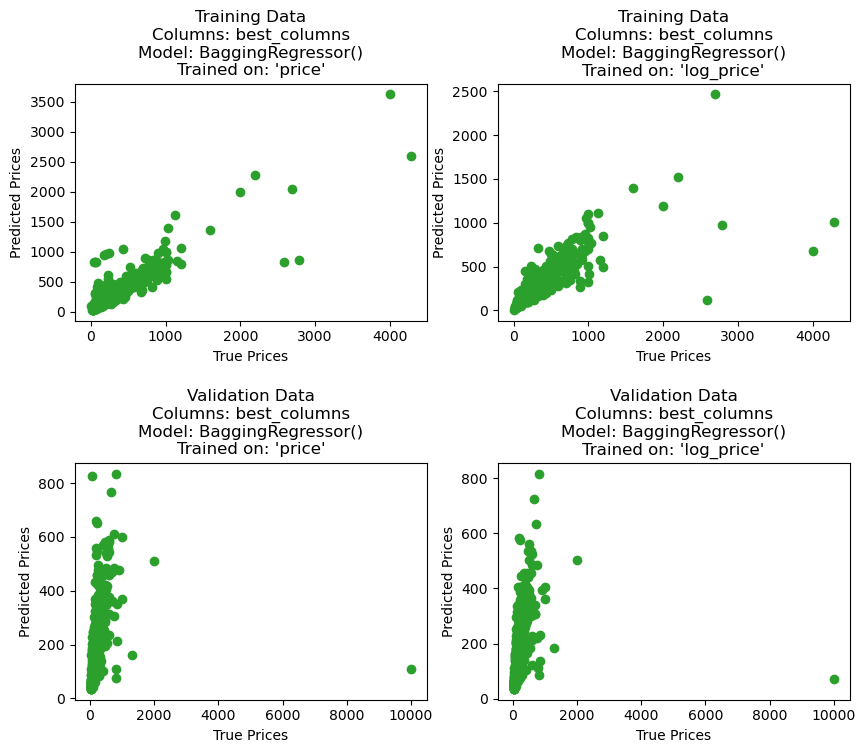



R2 training, price: 0.567
R2 training, log_price: 0.419
RMSE training, price: 137.036
RMSE training, log_price: 158.836

R2 validation, price: 0.062
R2 validation, log_price: 0.055
RMSE validation, price: 394.133
RMSE validation, log_price: 395.685


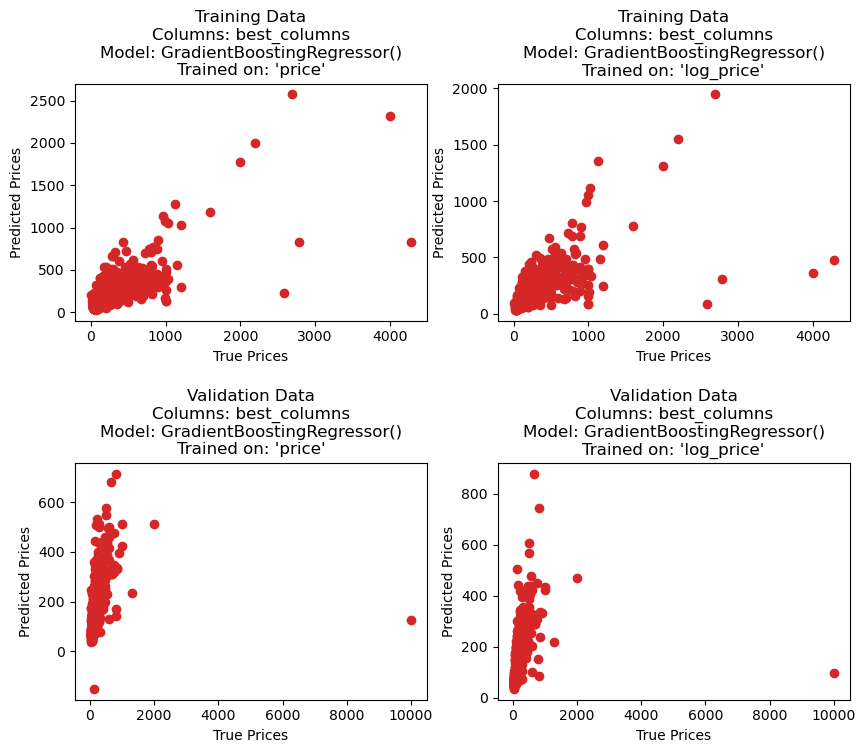



R2 training, price: 0.95
R2 training, log_price: 0.94
RMSE training, price: 46.574
RMSE training, log_price: 51.127

R2 validation, price: 0.036
R2 validation, log_price: 0.055
RMSE validation, price: 399.634
RMSE validation, log_price: 395.644


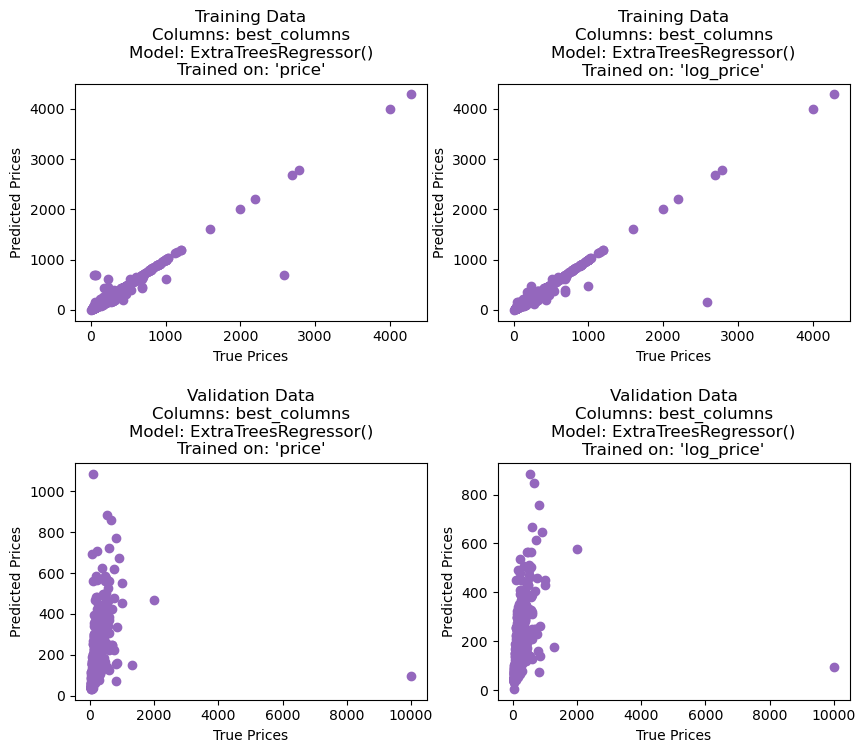



R2 training, price: 0.28
R2 training, log_price: 0.231
RMSE training, price: 176.718
RMSE training, log_price: 182.728

R2 validation, price: 0.007
R2 validation, log_price: 0.022
RMSE validation, price: 405.63
RMSE validation, log_price: 402.394


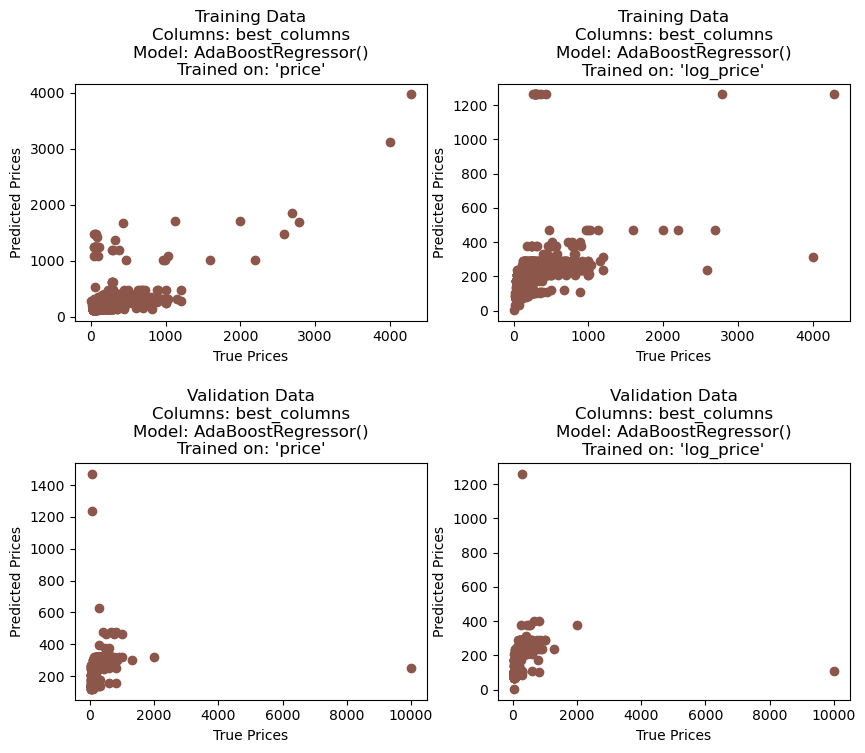



R2 training, price: 0.95
R2 training, log_price: 0.94
RMSE training, price: 46.574
RMSE training, log_price: 51.127

R2 validation, price: 0.032
R2 validation, log_price: 0.023
RMSE validation, price: 400.354
RMSE validation, log_price: 402.256


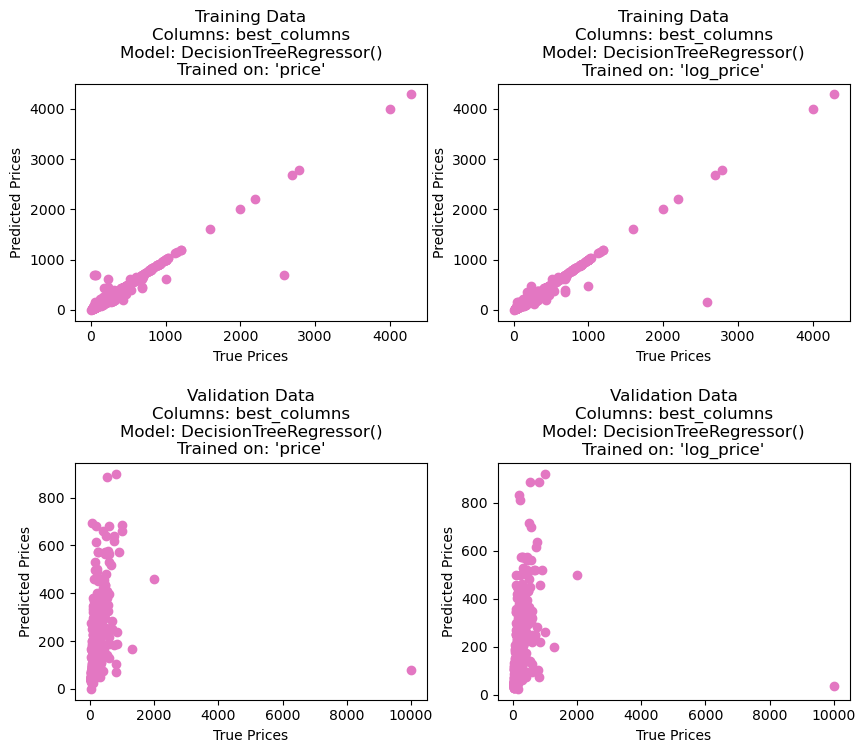

In [24]:
# Run the data maker function inside of the model maker function
model_maker(data_X_maker(lstn, validation, best_columns, 'best_columns'), 
            'best_columns', 
            list_of_models)

In [25]:
lstn.columns[0:11]

Index(['host_since', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bedrooms', 'beds', 'price'],
      dtype='object')

data_list_best_columns
(2781, 100)


R2 training, price: 0.411
R2 training, log_price: 0.391
RMSE training, price: 159.934
RMSE training, log_price: 162.534

R2 validation, price: 0.051
R2 validation, log_price: 0.058
RMSE validation, price: 396.472
RMSE validation, log_price: 394.985


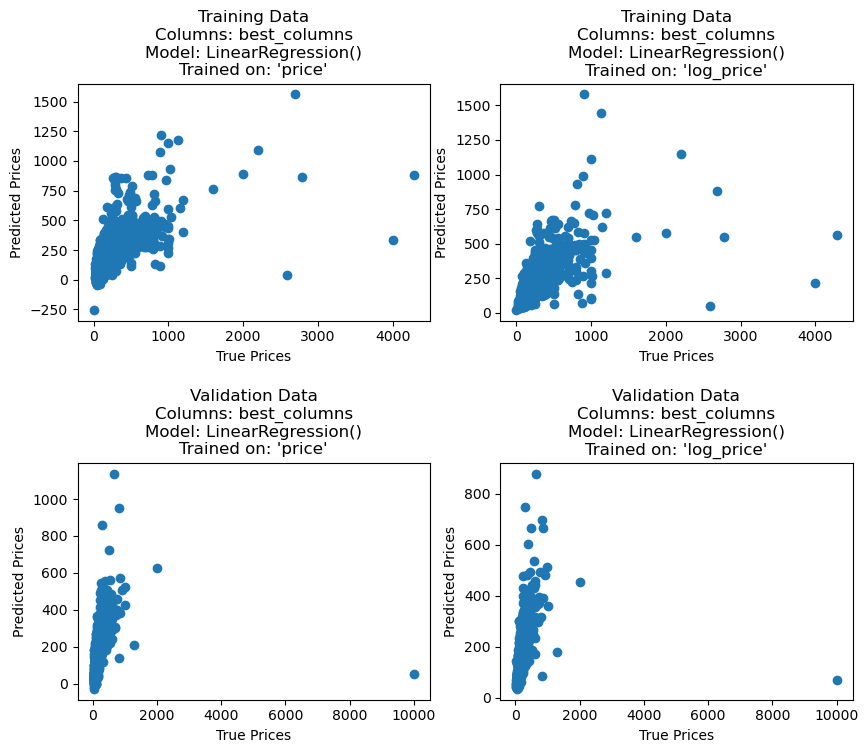



R2 training, price: 0.926
R2 training, log_price: 0.804
RMSE training, price: 56.816
RMSE training, log_price: 92.2

R2 validation, price: 0.054
R2 validation, log_price: 0.067
RMSE validation, price: 395.798
RMSE validation, log_price: 393.162


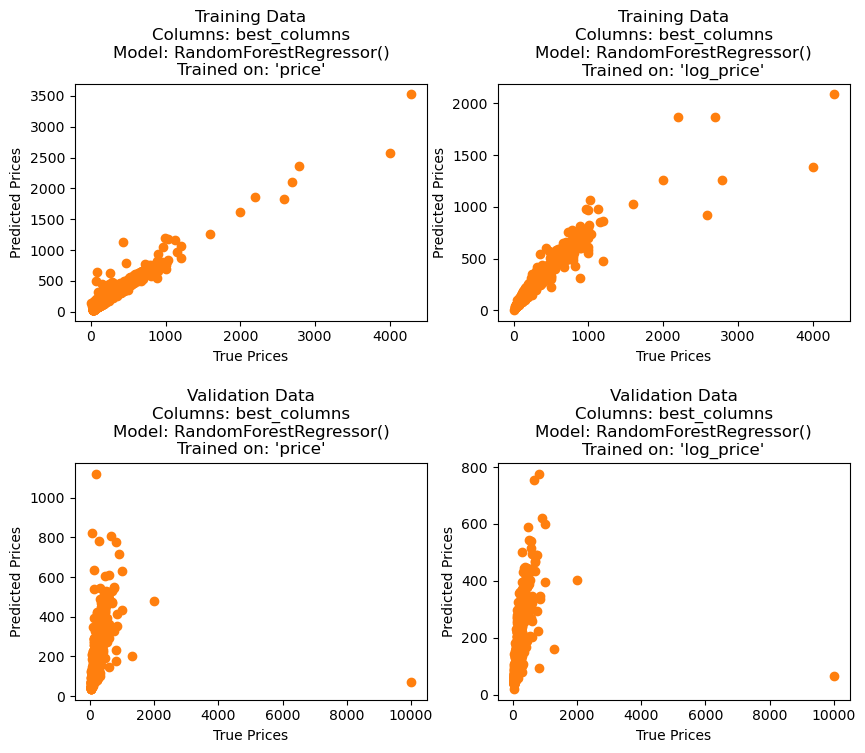



R2 training, price: 0.881
R2 training, log_price: 0.832
RMSE training, price: 71.939
RMSE training, log_price: 85.32

R2 validation, price: 0.052
R2 validation, log_price: 0.061
RMSE validation, price: 396.205
RMSE validation, log_price: 394.353


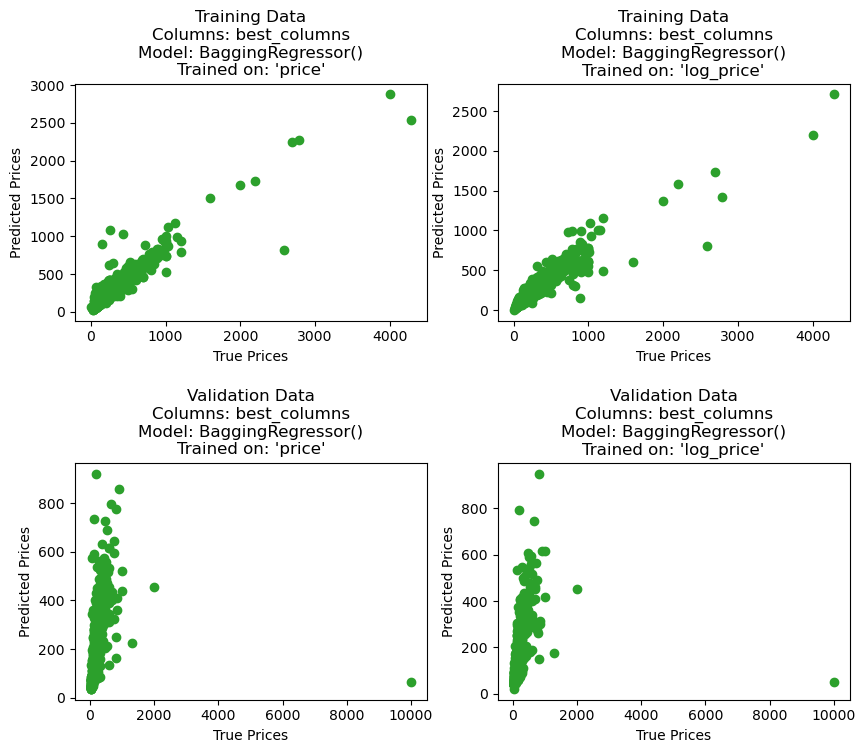



R2 training, price: 0.728
R2 training, log_price: 0.489
RMSE training, price: 108.719
RMSE training, log_price: 148.895

R2 validation, price: 0.061
R2 validation, log_price: 0.066
RMSE validation, price: 394.37
RMSE validation, log_price: 393.389


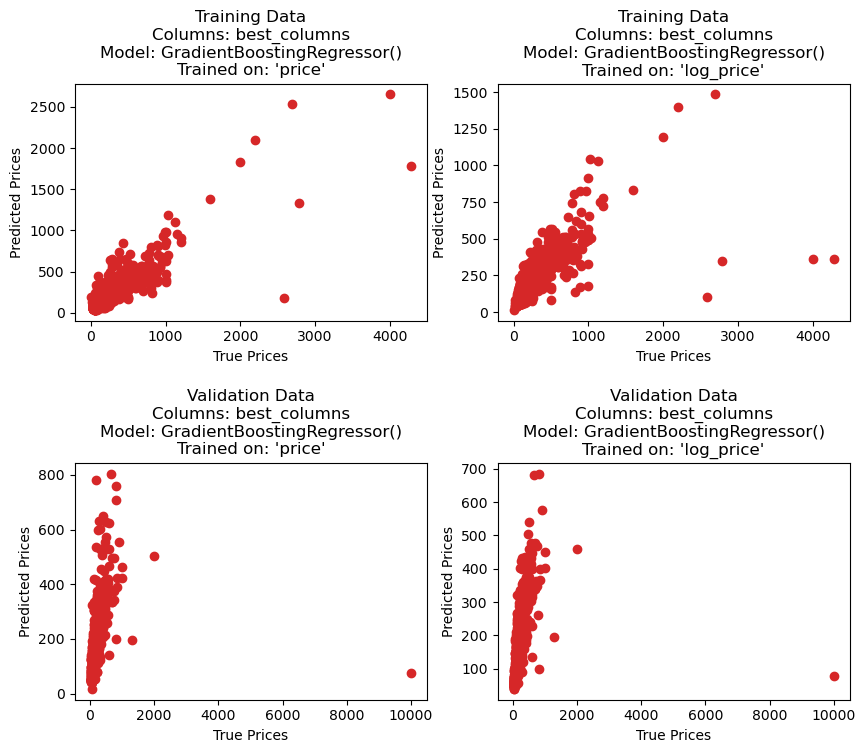



R2 training, price: 1.0
R2 training, log_price: 1.0
RMSE training, price: 0.551
RMSE training, log_price: 0.551

R2 validation, price: 0.073
R2 validation, log_price: 0.076
RMSE validation, price: 391.741
RMSE validation, log_price: 391.279


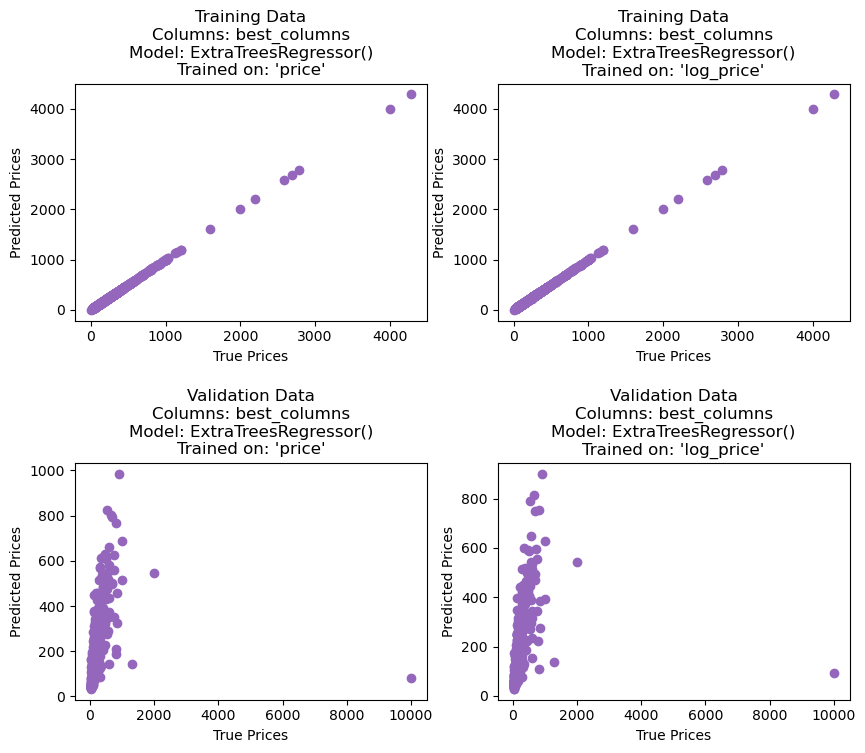



R2 training, price: 0.293
R2 training, log_price: 0.384
RMSE training, price: 175.199
RMSE training, log_price: 163.527

R2 validation, price: -0.02
R2 validation, log_price: 0.037
RMSE validation, price: 410.963
RMSE validation, log_price: 399.452


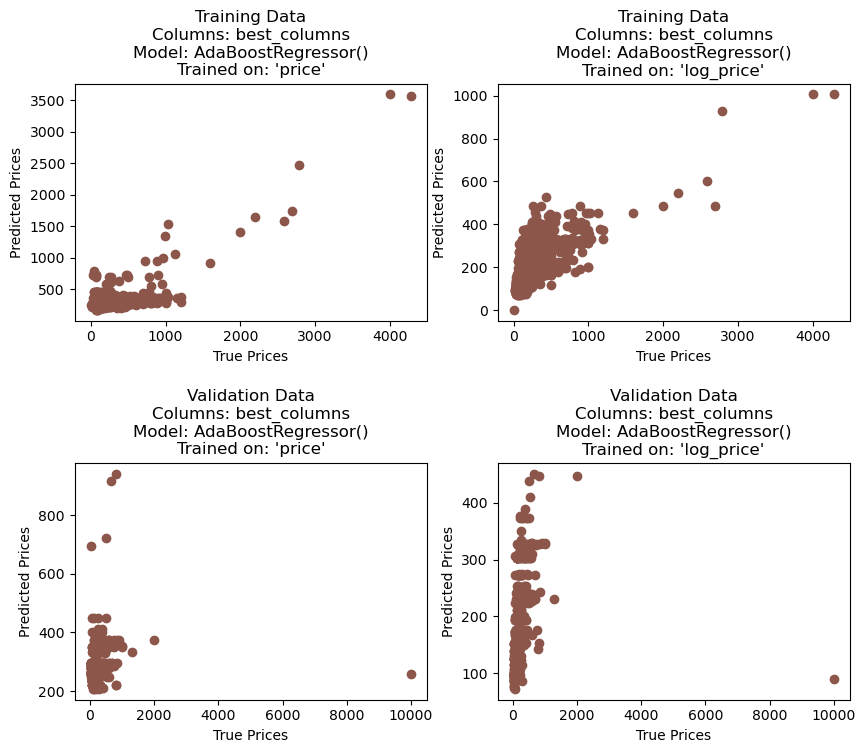



R2 training, price: 1.0
R2 training, log_price: 1.0
RMSE training, price: 0.551
RMSE training, log_price: 0.551

R2 validation, price: -0.185
R2 validation, log_price: 0.005
RMSE validation, price: 443.106
RMSE validation, log_price: 405.983


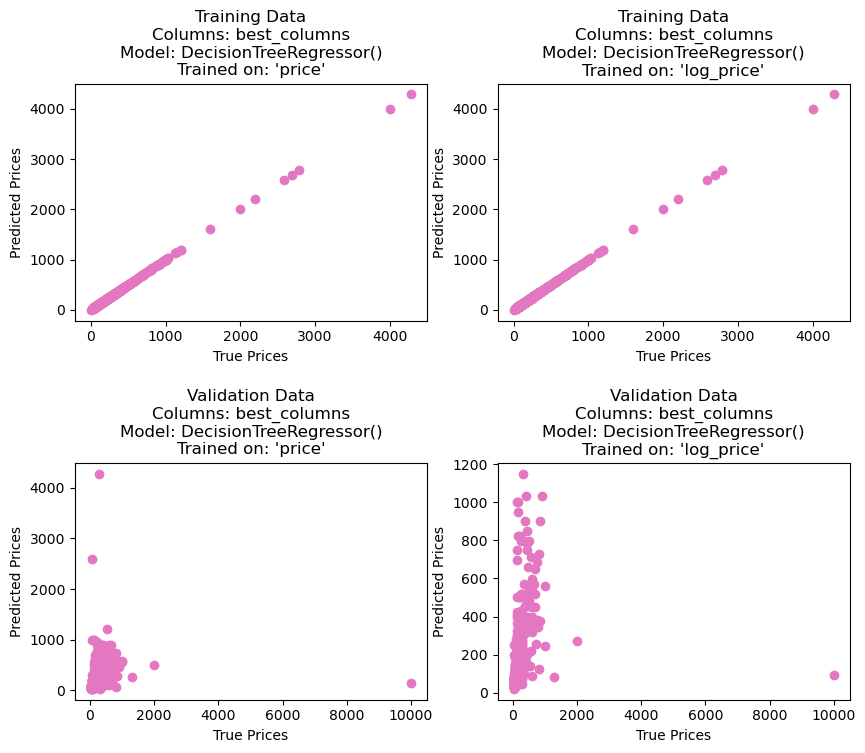

In [26]:
# Run the data maker function inside of the model maker function


super_col_list = list(lstn.columns)
super_col_list.remove('price')
super_col_list.remove('log_price')

model_maker(data_X_maker(lstn,
                         validation,
                         super_col_list[0:100], 
                         'best_columns'
                        ), 
            'best_columns', 
            list_of_models)

---
---
# Quick Recommender Test

In [80]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
# Need to create a sparse matrix from the dataframe
lstn_sparse = sparse.csr_matrix(lstn.drop(columns = ['price', 'log_price']))

# Calculate cosine distances
lstn_distances = cosine_distances(lstn_sparse)

In [61]:
lstn_similarities = cosine_similarity(lstn_sparse)

In [62]:
lstn_similarities

array([[1.        , 0.9999799 , 0.99898464, ..., 0.99995238, 0.99992754,
        0.99831269],
       [0.9999799 , 1.        , 0.9989273 , ..., 0.99995941, 0.99992367,
        0.99823207],
       [0.99898464, 0.9989273 , 1.        , ..., 0.99856622, 0.99858148,
        0.99969097],
       ...,
       [0.99995238, 0.99995941, 0.99856622, ..., 1.        , 0.99996121,
        0.99780594],
       [0.99992754, 0.99992367, 0.99858148, ..., 0.99996121, 1.        ,
        0.99772996],
       [0.99831269, 0.99823207, 0.99969097, ..., 0.99780594, 0.99772996,
        1.        ]])

In [63]:
rec = pd.DataFrame(lstn_similarities, index=lstn.index, columns=lstn.index)
rec

0         1         2         3         4         5         6     \
0     1.000000  0.999980  0.998985  0.996476  0.998994  0.998978  0.998831   
1     0.999980  1.000000  0.998927  0.996427  0.998871  0.998849  0.998755   
2     0.998985  0.998927  1.000000  0.995735  0.999647  0.999683  0.999869   
3     0.996476  0.996427  0.995735  1.000000  0.995385  0.995357  0.995272   
4     0.998994  0.998871  0.999647  0.995385  1.000000  0.999978  0.999889   
...        ...       ...       ...       ...       ...       ...       ...   
2776  0.998832  0.998732  0.999746  0.995218  0.999949  0.999927  0.999944   
2777  0.999021  0.998973  0.999903  0.995809  0.999760  0.999737  0.999911   
2778  0.999952  0.999959  0.998566  0.996465  0.998581  0.998566  0.998376   
2779  0.999928  0.999924  0.998581  0.996449  0.998458  0.998459  0.998284   
2780  0.998313  0.998232  0.999691  0.996556  0.999495  0.999475  0.999717   

          7         8         9     ...      2771      2772      2773  \
0     0.998772  0.998670  0.999749  ...  0.999118  0.999775  0.999765   
1     0.998693  0.998579  0.999787  ...  0.999045  0.999806  0.999824   
2     0.999868  0.999743  0.997987  ...  0.999768  0.997896  0.997947   
3     0.995198  0.995082  0.996192  ...  0.995520  0.996248  0.996230   
4     0.999835  0.999881  0.997990  ...  0.999927  0.997857  0.997840   
...        ...       ...       ...  ...       ...       ...       ...   
2776  0.999948  0.999983  0.997836  ...  0.999970  0.997619  0.997623   
2777  0.999938  0.999886  0.998114  ...  0.999902  0.997937  0.997974   
2778  0.998297  0.998194  0.999873  ...  0.998731  0.999915  0.999910   
2779  0.998239  0.998086  0.999845  ...  0.998625  0.999905  0.999892   
2780  0.999703  0.999643  0.997126  ...  0.999559  0.997003  0.997045   

          2774      2775      2776      2777      2778      2779      2780  
0     0.996368  0.999731  0.998832  0.999021  0.999952  0.999928  0.998313  
1     0.996361  0.999782  0.998732  0.998973  0.999959  0.999924  0.998232  
2     0.995831  0.997883  0.999746  0.999903  0.998566  0.998581  0.999691  
3     0.999933  0.996189  0.995218  0.995809  0.996465  0.996449  0.996556  
4     0.995218  0.997849  0.999949  0.999760  0.998581  0.998458  0.999495  
...        ...       ...       ...       ...       ...       ...       ...  
2776  0.995133  0.997677  1.000000  0.999874  0.998381  0.998269  0.999617  
2777  0.995869  0.997988  0.999874  1.000000  0.998604  0.998546  0.999758  
2778  0.996340  0.999880  0.998381  0.998604  1.000000  0.999961  0.997806  
2779  0.996350  0.999849  0.998269  0.998546  0.999961  1.000000  0.997730  
2780  0.996643  0.996997  0.999617  0.999758  0.997806  0.997730  1.000000  

[2781 rows x 2781 columns]

# Recommender Data Entry

In [191]:
'''
The purpose of this function is to allow one of the follwoing cells to
be used like a web page where a user would enter data for their desired
Airbnb listing.  Specifically, this function will allow for the empty 
lists next to each of the variables in the cell to operate as text entry 
fields which can be empty if the user chooses to omit that data.

Setting a variable but not equating it to anything will result in errors.

By running this function when a value is entered into on of the empty
text-entry lists, a value is then populated into a list corresponding to
the name of the column corresponding to that variable in the training data.
When nothing, is entered into a text entry list, this function will return 
nothing so that the list corresponding to the training data column will 
remain empty and can be easily dropped with a single dropna function.
'''

def listing_ft_returner(entry_list):
    if len(entry_list) == 1:
        return entry_list[0]
    elif len(entry_list) > 1:
        # Srouce to help with raising an error:
        #  https://rollbar.com/blog/throwing-exceptions-in-python/
        raise Exception('ONLY ONE ENTRY PLEASE!')
    else:
        return

In [253]:
# *********************  USER DESIRED AIRBNB LISTING FORM  *********************

# How many peopl ein your party ?
accommodates = [4] # (enter a number)

# How many separate bedrooms would you like?
bedrooms = [] # (enter a number)

# How many beds do you need?
beds = [] # (enter a number)

# What's the minimum number of nights you would plan to stay?
minimum_nightsroom_type_hotel_room = [] # (enter a number)

# Selected room type if desired
room_type_entire_home_apt = [] # enter 1 to select *
room_type_private_room = [] # enter 1 to select
room_type_shared_room = [] # enter 1 to select

# Available now?
has_availability_t = [] # enter 1 to select

# Select your neighborhood if desired
allston = [] # enter 1 to select *
back_bay = [] # enter 1 to select
bay_village = [] # enter 1 to select
beacon_hill = [] # enter 1 to select
brighton = [] # enter 1 to select
charlestown = [] # enter 1 to select
chinatown = [] # enter 1 to select
dorchester = [] # enter 1 to select
downtown = [] # enter 1 to select
east_boston = [] # enter 1 to select
fenway = [] # enter 1 to select
hyde_park = [] # enter 1 to select
jamaica_plain = [] # enter 1 to select
leather_district = [] # enter 1 to select
longwood_medical_area = [] # enter 1 to select
mattapan = [] # enter 1 to select
mission_hill = [] # enter 1 to select
north_end = [] # enter 1 to select
roslindale = [] # enter 1 to select
roxbury = [] # enter 1 to select
south_boston = [] # enter 1 to select
south_boston_waterfront = [] # enter 1 to select
south_end = [] # enter 1 to select
west_end = [] # enter 1 to select
west_roxbury = [] # enter 1 to select


# Select amenties if desired
wifi = [1] # enter 1 to select
kitchen = [] # enter 1 to select
essentials = [] # enter 1 to select
dedicated_workspace = [] # enter 1 to select
pets_allowed = [] # enter 1 to select
gym = [] # enter 1 to select
indoor_fireplace = [] # enter 1 to select
indoor_fireplace_electric = [] # enter 1 to select
fire_pit = [] # enter 1 to select
waterfront = [] # enter 1 to select
free_street_parking = [] # enter 1 to select
free_parking_on_premises = [] # enter 1 to select
patio_or_balcony = [] # enter 1 to select
backyard = [] # enter 1 to select
bbq_grill = [] # enter 1 to select
private_patio_or_balcony = [] # enter 1 to select
outdoor_dining_area = [] # enter 1 to select
pack_n_play_travel_crib = [] # enter 1 to select
childrens_books_and_toys = [] # enter 1 to select
board_games = [] # enter 1 to select
window_guards = [] # enter 1 to select
high_chair = [] # enter 1 to select

# * Note:  These variables were removed during one hot encode ing go nowhere...
#   In a future revision of this program, code must be added to specifically select these features
#    as merely selecting them does not actually zero-out the other columns

In [254]:
# This is where all the collumns are to to their vairables inside the functions

# Create the empty dataframe that will bepredicted upon
rec_data = pd.DataFrame(columns=lstn.columns)

# Create all the columns data
rec_data["accommodates"] = [listing_ft_returner(accommodates)]
rec_data["bedrooms"] = [listing_ft_returner(bedrooms)]
rec_data["beds"] = [listing_ft_returner(beds)]
rec_data["minimum_nightsroom_type_Hotel room"] = [listing_ft_returner(minimum_nightsroom_type_hotel_room)]
rec_data["room_type_Private room"] = [listing_ft_returner(room_type_private_room)]
rec_data["room_type_Shared room"] = [listing_ft_returner(room_type_shared_room)]
rec_data["has_availability_t"] = [listing_ft_returner(has_availability_t)]
rec_data["neighbourhood_cleansed_Back Bay"] = [listing_ft_returner(back_bay)]
rec_data["neighbourhood_cleansed_Bay Village"] = [listing_ft_returner(bay_village)]
rec_data["neighbourhood_cleansed_Beacon Hill"] = [listing_ft_returner(beacon_hill)]
rec_data["neighbourhood_cleansed_Brighton"] = [listing_ft_returner(brighton)]
rec_data["neighbourhood_cleansed_Charlestown"] = [listing_ft_returner(charlestown)]
rec_data["neighbourhood_cleansed_Chinatown"] = [listing_ft_returner(chinatown)]
rec_data["neighbourhood_cleansed_Dorchester"] = [listing_ft_returner(dorchester)]
rec_data["neighbourhood_cleansed_Downtown"] = [listing_ft_returner(downtown)]
rec_data["neighbourhood_cleansed_East Boston"] = [listing_ft_returner(east_boston)]
rec_data["neighbourhood_cleansed_Fenway"] = [listing_ft_returner(fenway)]
rec_data["neighbourhood_cleansed_Hyde Park"] = [listing_ft_returner(hyde_park)]
rec_data["neighbourhood_cleansed_Jamaica Plain"] = [listing_ft_returner(jamaica_plain)]
rec_data["neighbourhood_cleansed_Leather District"] = [listing_ft_returner(leather_district)]
rec_data["neighbourhood_cleansed_Longwood Medical Area"] = [listing_ft_returner(longwood_medical_area)]
rec_data["neighbourhood_cleansed_Mattapan"] = [listing_ft_returner(mattapan)]
rec_data["neighbourhood_cleansed_Mission Hill"] = [listing_ft_returner(mission_hill)]
rec_data["neighbourhood_cleansed_North End"] = [listing_ft_returner(north_end)]
rec_data["neighbourhood_cleansed_Roslindale"] = [listing_ft_returner(roslindale)]
rec_data["neighbourhood_cleansed_Roxbury"] = [listing_ft_returner(roxbury)]
rec_data["neighbourhood_cleansed_South Boston"] = [listing_ft_returner(south_boston)]
rec_data["neighbourhood_cleansed_South Boston Waterfront"] = [listing_ft_returner(south_boston_waterfront)]
rec_data["neighbourhood_cleansed_South End"] = [listing_ft_returner(south_end)]
rec_data["neighbourhood_cleansed_West End"] = [listing_ft_returner(west_end)]
rec_data["neighbourhood_cleansed_West Roxbury"] = [listing_ft_returner(west_roxbury)]
rec_data["amen_Wifi"] = [listing_ft_returner(wifi)]
rec_data["amen_Kitchen"] = [listing_ft_returner(kitchen)]
rec_data["amen_Essentials"] = [listing_ft_returner(essentials)]
rec_data["amen_Dedicated workspace"] = [listing_ft_returner(dedicated_workspace)]
rec_data["amen_Pets allowed"] = [listing_ft_returner(pets_allowed)]
rec_data["amen_Gym"] = [listing_ft_returner(gym)]
rec_data["amen_Indoor fireplace"] = [listing_ft_returner(indoor_fireplace)]
rec_data["amen_Indoor fireplace: electric"] = [listing_ft_returner(indoor_fireplace_electric)]
rec_data["amen_Fire pit"] = [listing_ft_returner(fire_pit)]
rec_data["amen_Waterfront"] = [listing_ft_returner(waterfront)]
rec_data["amen_Free street parking"] = [listing_ft_returner(free_street_parking)]
rec_data["amen_Free parking on premises"] = [listing_ft_returner(free_parking_on_premises)]
rec_data["amen_Patio or balcony"] = [listing_ft_returner(patio_or_balcony)]
rec_data["amen_Backyard"] = [listing_ft_returner(backyard)]
rec_data["amen_BBQ grill"] = [listing_ft_returner(bbq_grill)]
rec_data["amen_Private patio or balcony"] = [listing_ft_returner(private_patio_or_balcony)]
rec_data["amen_Outdoor dining area"] = [listing_ft_returner(outdoor_dining_area)]
rec_data["amen_Pack \\u2019n play/Travel crib"] = [listing_ft_returner(pack_n_play_travel_crib)]
rec_data["amen_Children\\u2019s books and toys"] = [listing_ft_returner(childrens_books_and_toys)]
rec_data["amen_Board games"] = [listing_ft_returner(board_games)]
rec_data["amen_Window guards"] = [listing_ft_returner(window_guards)]
rec_data["amen_High chair"] = [listing_ft_returner(high_chair)]

rec_data.dropna(axis=1, inplace=True)
rec_data

accommodates  amen_Wifi
0             4          1

# Predict Listing Price Based on User Inputs

In [342]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def listing_predictor(data_train, data_to_predict, model):
    
    # X Data    
    X_train_df  = data_train[data_to_predict.columns]
    X_val_df = data_to_predict
    
    # y dataset:    
    y_train = data_train['price']

    # **************  PRICE MODEL  ****************************************
    # Run Models on price
    model_instance = model
    model_instance.fit(X_train_df, y_train)

    # Predict      
    preds_price_val = model_instance.predict(X_val_df)
    
    return round(preds_price_val[0], 2)

In [363]:
rec_predict = listing_predictor(lstn[lstn.price < 1000], rec_data, LinearRegression())
rec_predict

208.91

# Find Similar Listings with Cosine Similarity

In [343]:
# Make a list of cosine similarities

sim_dict = {
    'listing_index': [],
    'similarity': [],
    'price': []
}

# Create a variable for the number of recommendations
num_recs = 30

'''
PLAN:
* make this a dictionary of the three values
* convert that dictionary to a dataframe
* Sort the dataframe by similarity, take the top 30
* find the minimum similarity value
* then find all listings with that similarity value
* of those, find the x number cheaper to complete the list of 30 cheapest units

'''

for index in lstn[lstn.price <300].index:
    
    # Calculate the similarity of the desired listing against each listing
    sim = cosine_similarity([(rec_data.iloc[0]), (lstn[rec_data.columns].iloc[index])])[0][1]
    
    # Append the listing index, similarity, and price to the dictionary
    sim_dict['listing_index'].append(index)
    sim_dict['similarity'].append(sim)
    sim_dict['price'].append(lstn['price'][index])

# Sort the listings by similarity score (descending) and then price (ascending)
# Soureces for help with this:
# * https://sparkbyexamples.com/pandas/pandas-sort-dataframe-by-multiple-columns/#:~:text=You%20can%20sort%20pandas%20DataFrame,descending%20and%20True%20for%20ascending.
# * https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
sim_df = pd.DataFrame(sim_dict).sort_values(by=['similarity', 'price'], ascending=[False, True])

AttributeError: module 'matplotlib.pyplot' has no attribute 'transAxes'

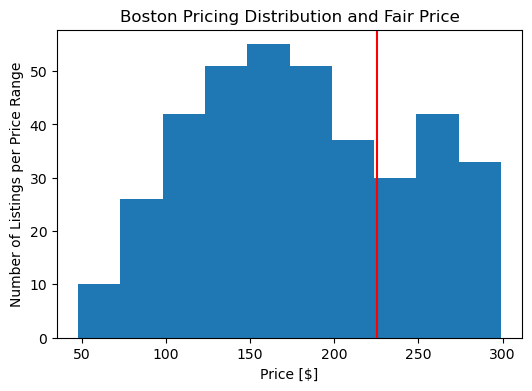

In [356]:
'''
The minimum and maximum similarities must be determined in order to report a logical amount of
of listings.  For example:  If the top n-number of suggestions are all the same similarity, then
technically, all others should be reported with the same similarity score - or at least the prices
for the identical similarity scores.

If the similarity scores are not the same, then simply report the top n-number of listings's prices.
'''
max_sim = sim_df['similarity'][0:num_recs].max()
min_sim = sim_df['similarity'][0:num_recs].min()

if max_sim == min_sim:
    # find all indexzes with that similarity
    suggested_indexes = sim_df[sim_df['similarity'] == min_sim]['listing_index']
    
    # Find all the prices for those indexes suggested above
    suggested_prices = sim_df[sim_df['similarity'] == min_sim]['price']
    
else:
    # Just give the top num_recs similarity differences
    suggested_indexes = sim_df[0:num_recs]['listing_index']
    
    # Find all the prices for those indexes suggested above
    suggested_prices = sim_df[0:num_recs]['listing_index']['price']

plt.figure(figsize = (6, 4))
plt.title('Boston Pricing Distribution and Fair Price')
plt.hist(suggested_prices, bins = 10)
plt.xlabel('Price [$]')
plt.ylabel('Number of Listings per Price Range')
plt.axvline(rec_predict, color = 'red')


# =========== REFORMAT THIS CODE TO WORK FOR YOU =======================

# textstr = '\n'.join((
#     r'$\mu=%.2f$' % (mu, ),
#     r'$\mathrm{median}=%.2f$' % (median, ),
#     r'$\sigma=%.2f$' % (sigma, )))

textstr = f'{rec_predict}'

#ax.hist(x, 50)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(0.05, 0.95, textstr, transform=plt.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# ======================= REFORMAT ABOVE CODE ==========================

# NOTE !!!! - may need to fix this code later to swap out lstn
lstn.iloc[suggested_indexes]

# JUNK

In [27]:
# '''
# Create a function that will create training and validation datasets based on a list of
# input columns against price and log_price data.  Do this only for the X data, y will 
# always be the same.
# '''

# def data_X_maker(col_list, col_list_name):
#     globals()[f'X_train_{col_list_name}']  = lstn_best[best_cols_no_mc]
#     print(f'X_train_{col_list_name}')
    
#     globals()[f'X_val_{col_list_name}'] = validation[best_cols_no_mc]
#     print(f'X_val_{col_list_name}')

    
    
# def model_maker(X_train_df, X_val_df, col_list_name, mod_list):
    
#     # Create common y datasets:
#     y_train = lstn['price']
#     y_val = validation['price']
    
#     y_train_log = lstn['log_price']
#     y_val_log = validation['log_price']

    
#     color_code = 0
    
#     for model in mod_list:
        
#         # Run Models on price
#         model_inst = model
#         model_inst.fit(X_train_df, y_train)
        
#         # Scores
#         r2_train_price = round(model_inst.score(X_train_df, y_train), 3)
#         r2_val_price = round(model_inst.score(X_val_df, y_val), 3)
        
#         preds_price_train = model_inst.predict(X_train_df)
#         preds_price_val = model_inst.predict(X_val_df)
        
#         # Run models on log price
#         model_inst_log = model
#         model_inst_log.fit(X_train_df, y_train_log)
        
#         # Scores
#         preds_log_price_train = np.exp(model_inst_log.predict(X_train_df))
#         preds_log_price_val = np.exp(model_inst_log.predict(X_val_df))
        
#         r2_train_log_price = round(r2_score(y_train, preds_log_price_train), 3)
#         r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)
        
#         print('\n')
#         print('=' * 50)       
#         print(f'R2 training, price: {r2_train_price}')
#         print(f'R2 training, log_price: {r2_train_log_price}\n')
#         #print('\n')
#         print(f'R2 validation, price: {r2_val_price}')
#         print(f'R2 validation, log_price: {r2_val_log_price}')
#         print('=' * 50)
                        
#         plt.figure(figsize = (10, 8))
#         plt.subplots_adjust(hspace=0.55)
        

#         plt.subplot(2, 2, 1)
#         plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
#         plt.scatter(y_train, preds_price_train, color = f'C{color_code}')
#         plt.xlabel('True Prices')
#         plt.ylabel('Predicted Prices')
        
#         plt.subplot(2, 2, 2)
#         plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
#         plt.scatter(y_train, preds_log_price_train, color = f'C{color_code}')
#         plt.xlabel('True Prices')
#         plt.ylabel('Predicted Prices')
        
        
#         plt.subplot(2, 2, 3)
#         plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
#         plt.scatter(y_val, preds_price_val, color = f'C{color_code}')
#         plt.xlabel('True Prices')        
#         plt.ylabel('Predicted Prices')
        
#         plt.subplot(2, 2, 4)
#         plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
#         plt.scatter(y_val, preds_log_price_val, color = f'C{color_code}')
#         plt.xlabel('True Prices')
#         plt.ylabel('Predicted Prices')
        
#         plt.show()
        
#         color_code += 1

In [28]:
# data_X_maker(lstn, validation, best_cols_no_mc, 'best_cols_no_mc');
# model_maker(data_list_best_cols_no_mc, 
#             'best_cols_no_mc', 
#             list_of_models)

# model_maker(X_train_best_cols_no_mc, X_val_best_cols_no_mc, 
#             'best_cols_no_mc', 
#             list_of_models)

In [29]:
# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
f'{fun=}'.split('=')[0]

NameError: name 'fun' is not defined

In [116]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def data_X_maker(data_train, data_val, col_list, single_prediction):
    
    col_list_name = f'{col_list=}'
    
    globals()[f'X_train_{col_list_name}']  = data_train[col_list]
    #print(f'X_train_{col_list_name}')
    
    globals()[f'X_val_{col_list_name}'] = data_val[col_list]
    #print(f'X_val_{col_list_name}')
    
    # Create common y datasets:
    globals()[f'y_train_{col_list_name}'] = data_train['price']
    #print(f'y_train_{col_list_name}')
    
    globals()[f'y_train_log_{col_list_name}'] = data_train['log_price']
    #print(f'y_train_log_{col_list_name}')
    
    # Create an if statemetn to skip the creation of certain data for a single prediction
    if single_prediction == True:
        pass
    
    else:
        globals()[f'y_val_{col_list_name}'] = data_val['price']
        #print(f'y_val_{col_list_name}')

        globals()[f'y_val_log_{col_list_name}'] = data_val['log_price']
        #print(f'y_val_log_{col_list_name}')
    
    
    # Create dataframes for modeling:
    globals()[f'data_list_{col_list_name}'] = [
        globals()[f'X_train_{col_list_name}'],
        globals()[f'X_val_{col_list_name}'],
        globals()[f'y_train_{col_list_name}'],
        globals()[f'y_train_log_{col_list_name}'],
    ]
    
    # Ignore y_val's if a single prediction:
    if single_prediction == True:
        pass
    
    else:
        globals()[f'data_list_{col_list_name}'].append(globals()[f'y_val_{col_list_name}'])
        globals()[f'data_list_{col_list_name}'].append(globals()[f'y_val_log_{col_list_name}'])
     
    # Print the name of the list of dataframes for reference
    print(f'data_list_{col_list_name}')
    
    return globals()[f'data_list_{col_list_name}']

def model_maker(data_list, col_list_name, mod_list):
    
    # Detect the length of the dataframe to see if y_val and y_val_log are present
    #  Detects whether or not it's a single predict without asking as an argument
    dl_len = len(data_list)
    
    if dl_len == 4 and len(mod_list) > 1:
        print('HEY!!!!!!  ONLY ONE MODEL PLEASE!!!!!!!!')
    
    else:
        # Import data from a data list grabbing each component by index
        # X Data
        X_train_df = data_list[0]
        X_val_df = data_list[1]

        print(f'{X_train_df.shape}')

        # y datasets:
        y_train = data_list[2]
        y_train_log = data_list[3]

        if dl_len > 4:
            y_val = data_list[4]
            y_val_log = data_list[5]
        else:
            pass

        # This is to change colors for each model so they're easier to identify
        color_code = 0
        
        if dl_len == 4:
            pass
        
        else:
            # This is a dictionary which will house all metrics comupted in this loop
            modeling_dictionary = {'col_data': [], 
                         'model':[], 
                         'R2 training, price': [], 
                         'R2 training, log_price': [], 
                         'RMSE training, price': [],
                         'RMSE training, log_price': [],
                         'R2 validation, price': [],
                         'R2 validation, log_price': [],
                         'RMSE validation, price': [],
                         'RMSE validation, log_price': []                 
                        }

        # Run the for loop to run all models in the input list on the data
        for model in mod_list:

            # **************  PRICE MODEL  ****************************************
            # Run Models on price
            model_inst = model
            model_inst.fit(X_train_df, y_train)
            
            # Scores      
            preds_price_train = model_inst.predict(X_train_df)
            preds_price_val = model_inst.predict(X_val_df)
            
            if dl_len == 4:
                return preds_price_val
            
            else:                
                r2_train_price = round(model_inst.score(X_train_df, y_train), 3)
                r2_val_price = round(r2_score(y_val, preds_price_val), 3)

                rmse_train_price = round(mean_squared_error(y_train, preds_price_train, squared = False), 3)
                rmse_val_price = round(mean_squared_error(y_val, preds_price_val, squared = False), 3)


                # ***************  LOG PRICE MODEL  ***************************************
                # Run models on log price
                model_inst_log = model
                model_inst_log.fit(X_train_df, y_train_log)

                # Scores
                preds_log_price_train = np.exp(model_inst_log.predict(X_train_df))
                preds_log_price_val = np.exp(model_inst_log.predict(X_val_df))

                r2_train_log_price = round(r2_score(y_train, preds_log_price_train), 3)
                r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)

                rmse_train_log_price = round(mean_squared_error(y_train, preds_log_price_train, squared = False), 3)
                rmse_val_log_price = round(mean_squared_error(y_val, preds_log_price_val, squared = False), 3)


                # Append values to dictionary:
                modeling_dictionary['col_data'].append(col_list_name)
                modeling_dictionary['model'].append(f'{model}'), 
                modeling_dictionary['R2 training, price'].append(r2_train_price) 
                modeling_dictionary['R2 training, log_price'].append(r2_train_log_price) 
                modeling_dictionary['RMSE training, price'].append(rmse_train_price)
                modeling_dictionary['RMSE training, log_price'].append(rmse_train_log_price)
                modeling_dictionary['R2 validation, price'].append(r2_val_price)
                modeling_dictionary['R2 validation, log_price'].append(r2_val_log_price)
                modeling_dictionary['RMSE validation, price'].append(rmse_val_price)
                modeling_dictionary['RMSE validation, log_price'].append(rmse_val_log_price)

                # Print the metrics so they can be viewed
                print('\n')
                print('=' * 50)       
                print(f'R2 training, price: {r2_train_price}')
                print(f'R2 training, log_price: {r2_train_log_price}')

                print(f'RMSE training, price: {rmse_train_price}')
                print(f'RMSE training, log_price: {rmse_train_log_price}\n')

                #print('\n')
                print(f'R2 validation, price: {r2_val_price}')
                print(f'R2 validation, log_price: {r2_val_log_price}')

                print(f'RMSE validation, price: {rmse_val_price}')
                print(f'RMSE validation, log_price: {rmse_val_log_price}')


                print('=' * 50)

                plt.figure(figsize = (10, 8))
                plt.subplots_adjust(hspace=0.6)

                plt.subplot(2, 2, 1)
                plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
                plt.scatter(y_train, preds_price_train, color = f'C{color_code}')
                plt.xlabel('True Prices')
                plt.ylabel('Predicted Prices')

                plt.subplot(2, 2, 2)
                plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
                plt.scatter(y_train, preds_log_price_train, color = f'C{color_code}')
                plt.xlabel('True Prices')
                plt.ylabel('Predicted Prices')

                plt.subplot(2, 2, 3)
                plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
                plt.scatter(y_val, preds_price_val, color = f'C{color_code}')
                plt.xlabel('True Prices')        
                plt.ylabel('Predicted Prices')

                plt.subplot(2, 2, 4)
                plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
                plt.scatter(y_val, preds_log_price_val, color = f'C{color_code}')
                plt.xlabel('True Prices')
                plt.ylabel('Predicted Prices')

                plt.show()

                # Up the color code for the next model
                color_code += 1

            '''
            The follwoing formatting code was inspired by the following sources:
            * My project 3
            * https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
            * https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.highlight_max.html
            * Assking ChatGPT:  "i need an example of using the subset argument in a pandas dataframe formatted with style.highlight_max"
            * https://medium.com/gustavorsantos/how-to-highlight-max-min-or-nulls-with-pandas-f2df5bf4ccf9
            '''
            return pd.DataFrame(modeling_dictionary).style\
        .highlight_max(subset = ['R2 training, price', 'R2 training, log_price', 'R2 validation, price', 'R2 validation, log_price'], color = 'darkred')\
        .highlight_min(subset = ['RMSE training, price', 'RMSE training, log_price', 'RMSE validation, price', 'RMSE validation, log_price'], color = 'blue')

In [227]:
# for the variables, remove the prefixes and replace all spaces

var_list = []

for i in coding_list:
#     var_list.append('listing_ft_returner('+i.replace('neighbourhood_cleansed_', '')\
#                     .replace(' ', '_').replace('amen_', '')\
#                     .replace('\\u2019', '').lower() + ')' + ' = []')
    
    var_list.append(i.replace('neighbourhood_cleansed_', '')\
                .replace(' ', '_').replace('amen_', '')\
                .replace('\\u2019', '').lower() + ' = []')

# for the columns, add brackets and the word 'rec_data' in front to all the colmns
rec_col_list = []

for col in coding_list:
    rec_col_list.append(f'rec_data["{col}"]')

# Finally, join them together using indexes, add a carriage return at the end of each

codez = []

for index in range(len(var_list)):
    codez.append(f'{rec_col_list[index]} = {var_list[index]}')

In [173]:
rec_cols = ['accommodates', 
'bedrooms', 
'beds', 
'minimum_nights',
'room_type_Hotel room',
'room_type_Private room', 
'room_type_Shared room',
'has_availability_t']

In [211]:
coding_list = [
    'minimum_nights'
    'room_type_Hotel room',
    'room_type_Private room', 
    'room_type_Shared room',
    'has_availability_t', 
    'neighbourhood_cleansed_Back Bay',
    'neighbourhood_cleansed_Bay Village',
    'neighbourhood_cleansed_Beacon Hill', 
    'neighbourhood_cleansed_Brighton',
    'neighbourhood_cleansed_Charlestown',
    'neighbourhood_cleansed_Chinatown', 
    'neighbourhood_cleansed_Dorchester',
    'neighbourhood_cleansed_Downtown', 
    'neighbourhood_cleansed_East Boston',
    'neighbourhood_cleansed_Fenway', 
    'neighbourhood_cleansed_Hyde Park',
    'neighbourhood_cleansed_Jamaica Plain',
    'neighbourhood_cleansed_Leather District',
    'neighbourhood_cleansed_Longwood Medical Area',
    'neighbourhood_cleansed_Mattapan',
    'neighbourhood_cleansed_Mission Hill',
    'neighbourhood_cleansed_North End', 
    'neighbourhood_cleansed_Roslindale',
    'neighbourhood_cleansed_Roxbury', 
    'neighbourhood_cleansed_South Boston',
    'neighbourhood_cleansed_South Boston Waterfront',
    'neighbourhood_cleansed_South End', 
    'neighbourhood_cleansed_West End',
    'neighbourhood_cleansed_West Roxbury', 
    'amen_Wifi',
    'amen_Kitchen',
    'amen_Essentials',
    'amen_Dedicated workspace',
    'amen_Pets allowed',
    'amen_Gym',
    'amen_Indoor fireplace',
    'amen_Indoor fireplace: electric',
    'amen_Fire pit',
    'amen_Waterfront',
    'amen_Free street parking',
    'amen_Free parking on premises',
    'amen_Patio or balcony',
    'amen_Backyard',
    'amen_BBQ grill',
    'amen_Private patio or balcony',
    'amen_Outdoor dining area',
    'amen_Pack \\u2019n play/Travel crib',
    'amen_Children\\u2019s books and toys',
    'amen_Board games',
    'amen_Window guards',
    'amen_High chair'
]

In [79]:
cosine_similarity([[1, 0, 100], [1, 0, 0]])

array([[1.       , 0.0099995],
       [0.0099995, 1.       ]])

In [281]:
cosine_similarity([(rec_data.iloc[0]), 
                   (lstn[rec_data.columns].iloc[0])])[0][1]

0.9988681377244376